# Interest Rate prediction (Classification and Unsupervised Learning).

###### Importing Libraries

In [ ]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

###### Loading the dataset

In [ ]:
train = pd.read_csv('Data/capstone_train.csv')

### 5 point summary of the data

In [12]:
#Numerical Variables
train.describe().T

count          mean           std         min  \
Loan_ID                  164309.0  1.008216e+07  47432.067027  10000001.0   
Annual_Income            139207.0  7.333116e+04  60377.498294      4000.0   
Debt_To_Income           164309.0  1.720719e+01      7.845083         0.0   
Inquiries_Last_6Mo       164309.0  7.816979e-01      1.034747         0.0   
Months_Since_Deliquency   75930.0  3.422936e+01     21.761180         0.0   
Number_Open_Accounts     164309.0  1.119382e+01      4.991813         0.0   
Total_Accounts           164309.0  2.506767e+01     11.583067         2.0   
Interest_Rate            164309.0  2.158951e+00      0.738364         1.0   

                                 25%          50%          75%          max  
Loan_ID                  10041078.00  10082155.00  10123232.00  10164309.00  
Annual_Income               45000.00     63000.00     88697.50   7500000.00  
Debt_To_Income                 11.37        16.84        22.78        39.99  
Inquiries_Last_6Mo              0.00         0.00         1.00         8.00  
Months_Since_Deliquency        16.00        31.00        50.00       180.00  
Number_Open_Accounts            8.00        10.00        14.00        76.00  
Total_Accounts                 17.00        23.00        32.00       156.00  
Interest_Rate                   2.00         2.00         3.00         3.00

In [13]:
#Categorical Variables
train.select_dtypes('object').describe().T

count unique                 top    freq
Loan_Amount_Requested  164309   1290              10,000   11622
Length_Employed        156938     11           10+ years   52915
Home_Owner             138960      5            Mortgage   70345
Income_Verified        164309      3   VERIFIED - income   59421
Purpose_Of_Loan        164309     14  debt_consolidation   97101
Gender                 164309      2                Male  117176

###### Coefficient of Variance for numerical columns

* std/mean

In [14]:
np.std(train.drop('Loan_ID',axis = 1).select_dtypes(np.number))/np.mean(train.drop('Loan_ID',axis = 1).select_dtypes(np.number))

Annual_Income              0.823351
Debt_To_Income             0.455918
Inquiries_Last_6Mo         1.323713
Months_Since_Deliquency    0.635742
Number_Open_Accounts       0.445942
Total_Accounts             0.462071
Interest_Rate              0.342000
dtype: float64

### Checking for missing values and their relationship with the target variable

In [15]:
train.isna().sum()[train.isna().sum()!=0]/len(train)
#Ignore the interest rate since that is the target variable.

Length_Employed            0.044861
Home_Owner                 0.154276
Annual_Income              0.152773
Months_Since_Deliquency    0.537883
dtype: float64

#### Problems in the dataset
* Drop Loan_ID since it is unique to each record and will not have any predictive power.
* Months_Since_Deliquency seems to have more than 50% of missing values. Let us check its relationship with the target variable.
* Loan_Amount_Requested is coming as a categorical column which is not correct. 
* Inquiries_Last_6_Mo seems to have lot of zeros according to the description.


In [16]:
train.drop('Loan_ID',axis = 1,inplace = True)

###### Checking Correlation

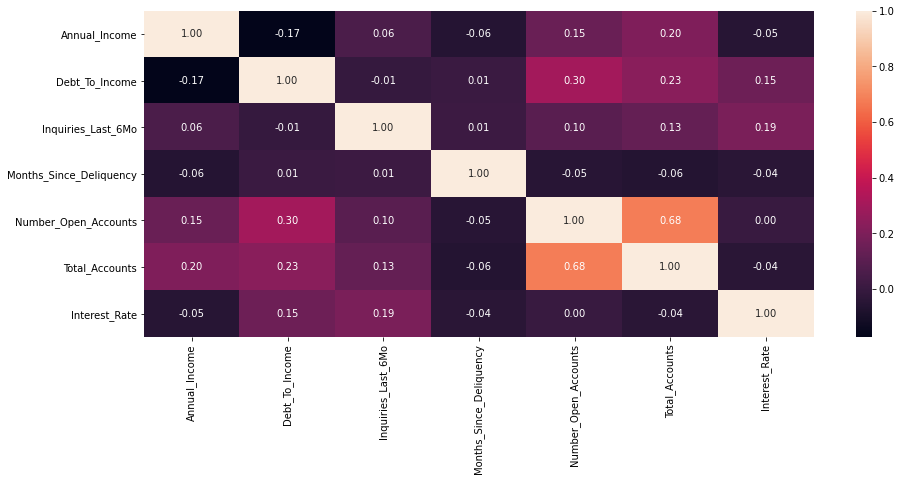

In [17]:
plt.figure(figsize = (15,6))
sns.heatmap(train.corr(),annot = True,fmt = '.2f')
plt.show()

###### Strong correlation between total_accounts and open accounts suggests that we can drop one of the two columns

###### Converting Loan Amount requested into numeric

In [18]:
def lar(x):
    return int(x.replace(',',''))
train['Loan_Amount_Requested'] = train['Loan_Amount_Requested'].apply(lar)

# Univariate Analysis

###### Interest_Rate (Target Variable)

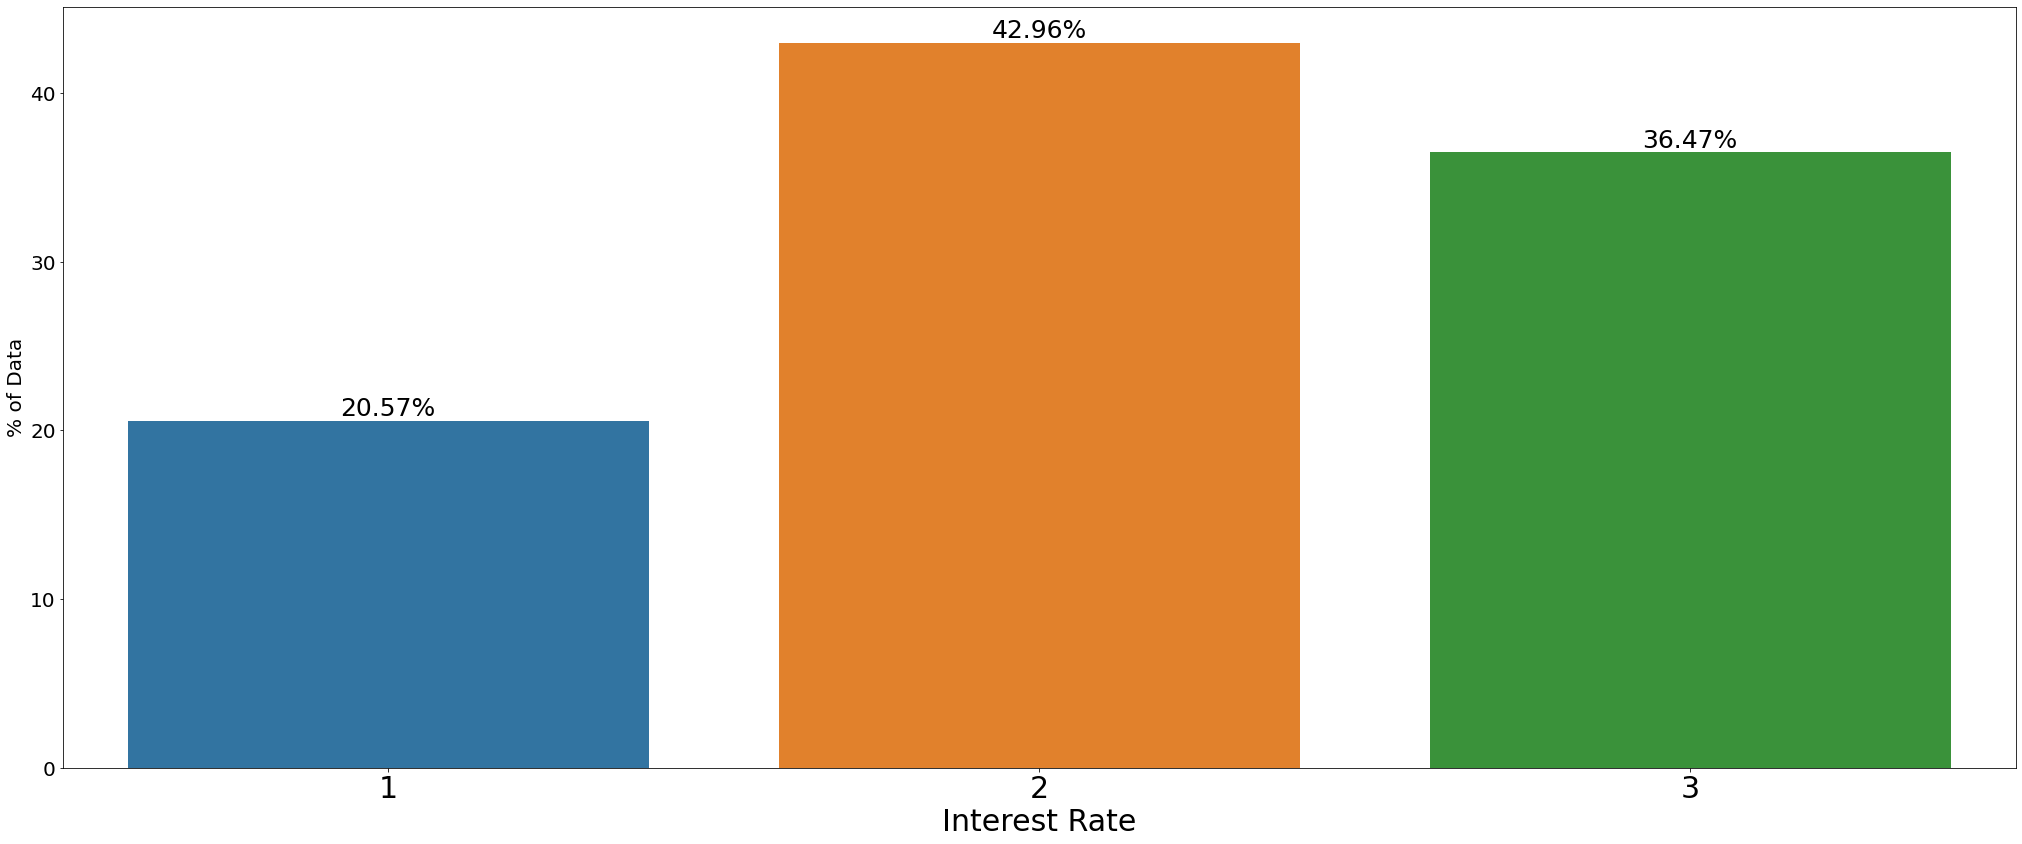

In [59]:
ir_cnt = round(train['Interest_Rate'].value_counts()/len(train)*100,2).sort_values(ascending = False)
plt.figure(figsize = (35,14))
plots = sns.barplot(ir_cnt.index,ir_cnt.values,orient = 'v')

for bar in plots.patches:   
  # Using Matplotlib's annotate function and 
  # passing the coordinates where the annotation shall be done 
  # x-coordinate: bar.get_x() + bar.get_width() / 2 
  # y-coordinate: bar.get_height() 
  # free space to be left to make graph pleasing: (0, 8) 
  # ha and va stand for the horizontal and vertical alignment 
    plots.annotate(format(bar.get_height(), '.2f')+'%',  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=25, xytext=(0,12), 
                   textcoords='offset points') 

plt.xticks(fontsize=30)
plt.ylabel('% of Data',fontsize = 20)
plt.xlabel('Interest Rate',fontsize = 30)
plt.yticks(fontsize=20)
plt.show()
#There is some disbalance in the dataset. We could perform over or under sampling

In [20]:
#We can try to apply SMOTE or perform undersampling during the model building process to see which does better.

### Distribution Plots

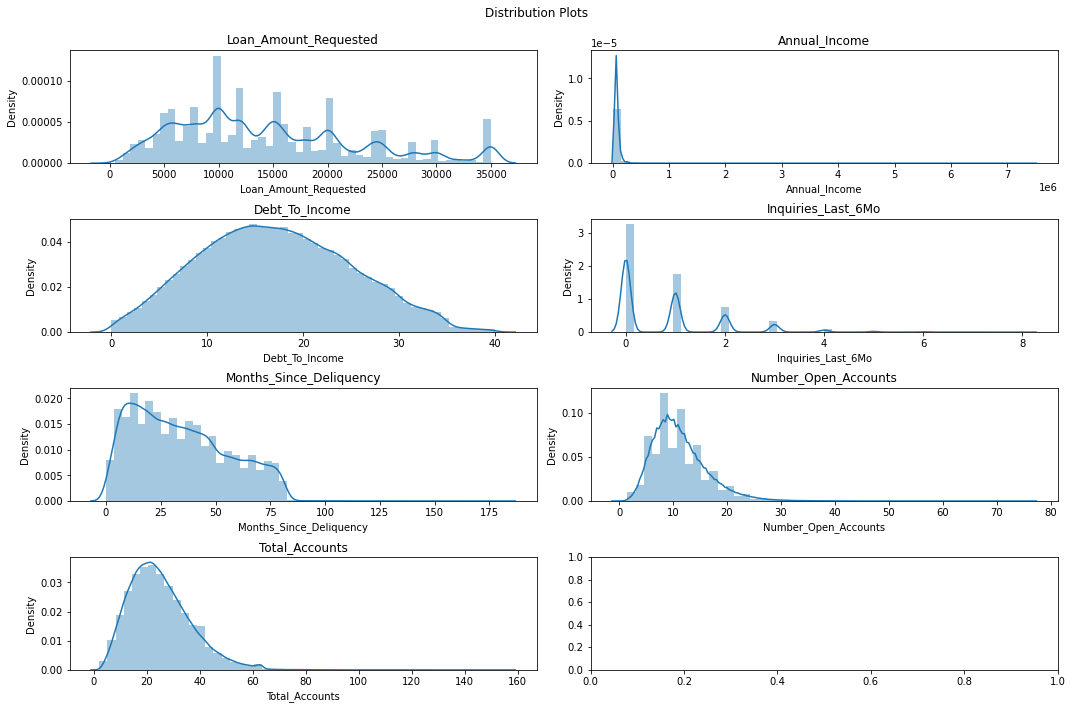

In [21]:
dist_data = train.select_dtypes(np.number).drop('Interest_Rate',axis = 1)
fig,ax = plt.subplots(4,2,figsize = (15,10))
for variables,plotsubs in zip(dist_data.columns,ax.flatten()):
    plotsubs.set_title(variables)
    sns.distplot(dist_data[variables],ax = plotsubs)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.92)
fig.suptitle('Distribution Plots')
plt.show()

###### We will apply log_transformation to total_accounts,months_since_deliquency,number_open_accounts,annual_income after imputing the data

###### There are outliers present in the dataset

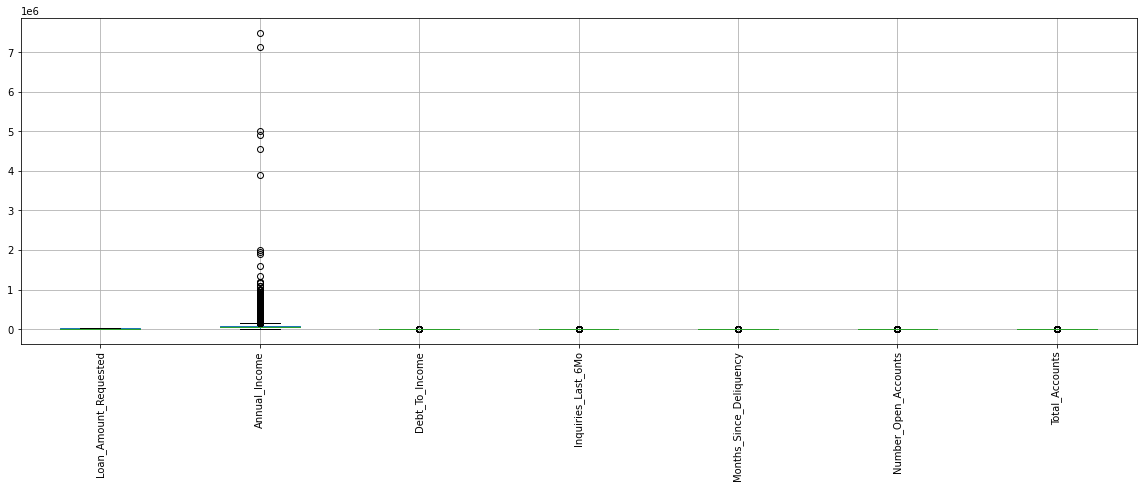

In [22]:
#Checking for outliers using boxplots
plt.figure(figsize = (20,6))
dist_data.boxplot()
plt.xticks(rotation = 90)
plt.show()

###### Annual_Income seems to come with a lot of outliers. Let us plot each individual boxplot as well

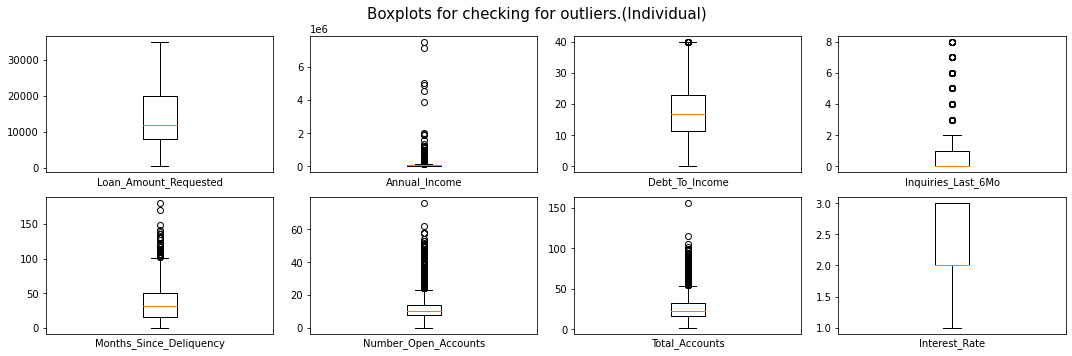

In [23]:
fig,ax = plt.subplots(nrows = 2,ncols = 4,figsize = (15,5))

for variables,plotsubs in zip(train.select_dtypes(np.number).columns,ax.flatten()):
    
    plotsubs.tick_params(labelsize = 10)
    plotsubs.boxplot(train[variables].dropna())
    plotsubs.set_xticks([])
    plotsubs.set_xlabel(variables,fontsize = 10)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('Boxplots for checking for outliers.(Individual)',fontsize = 15)
plt.show()

###### Almost all the columns come with outliers except Amt Requested and Debt_To_Income

## Removing Outliers

In [24]:
Q1 = train.drop(['Inquiries_Last_6Mo','Months_Since_Deliquency'],axis = 1).quantile(0.25)
Q3 = train.drop(['Inquiries_Last_6Mo','Months_Since_Deliquency'],axis = 1).quantile(0.75)
IQR = Q3-Q1
train_data1 = train[~((train<(Q1-1.5*IQR)) | (train>(Q3+1.5*IQR))).any(axis = 1)]

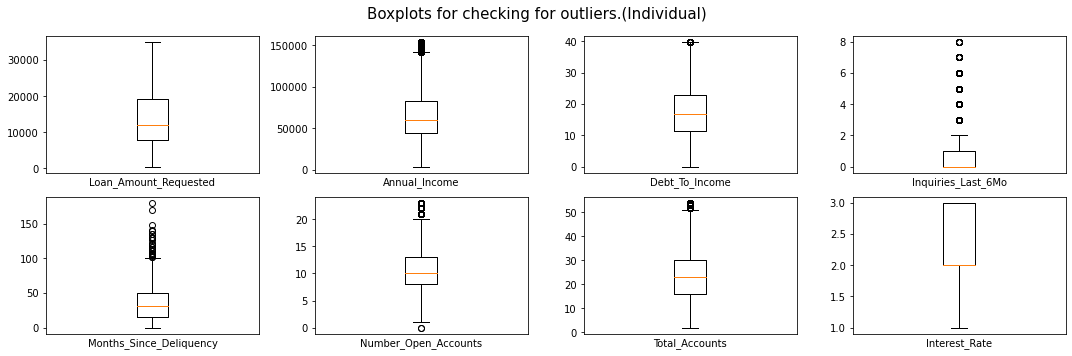

In [25]:
fig,ax = plt.subplots(nrows = 2,ncols = 4,figsize = (15,5))

for variables,plotsubs in zip(train_data1.select_dtypes(np.number).columns,ax.flatten()):
    
    plotsubs.tick_params(labelsize = 10)
    plotsubs.boxplot(train_data1[variables].dropna())
    plotsubs.set_xticks([])
    plotsubs.set_xlabel(variables,fontsize = 10)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('Boxplots for checking for outliers.(Individual)',fontsize = 15)
plt.show()

###### As we can observe from the above figure, we have got rid of outliers in the dataset.

### Proportion Plots

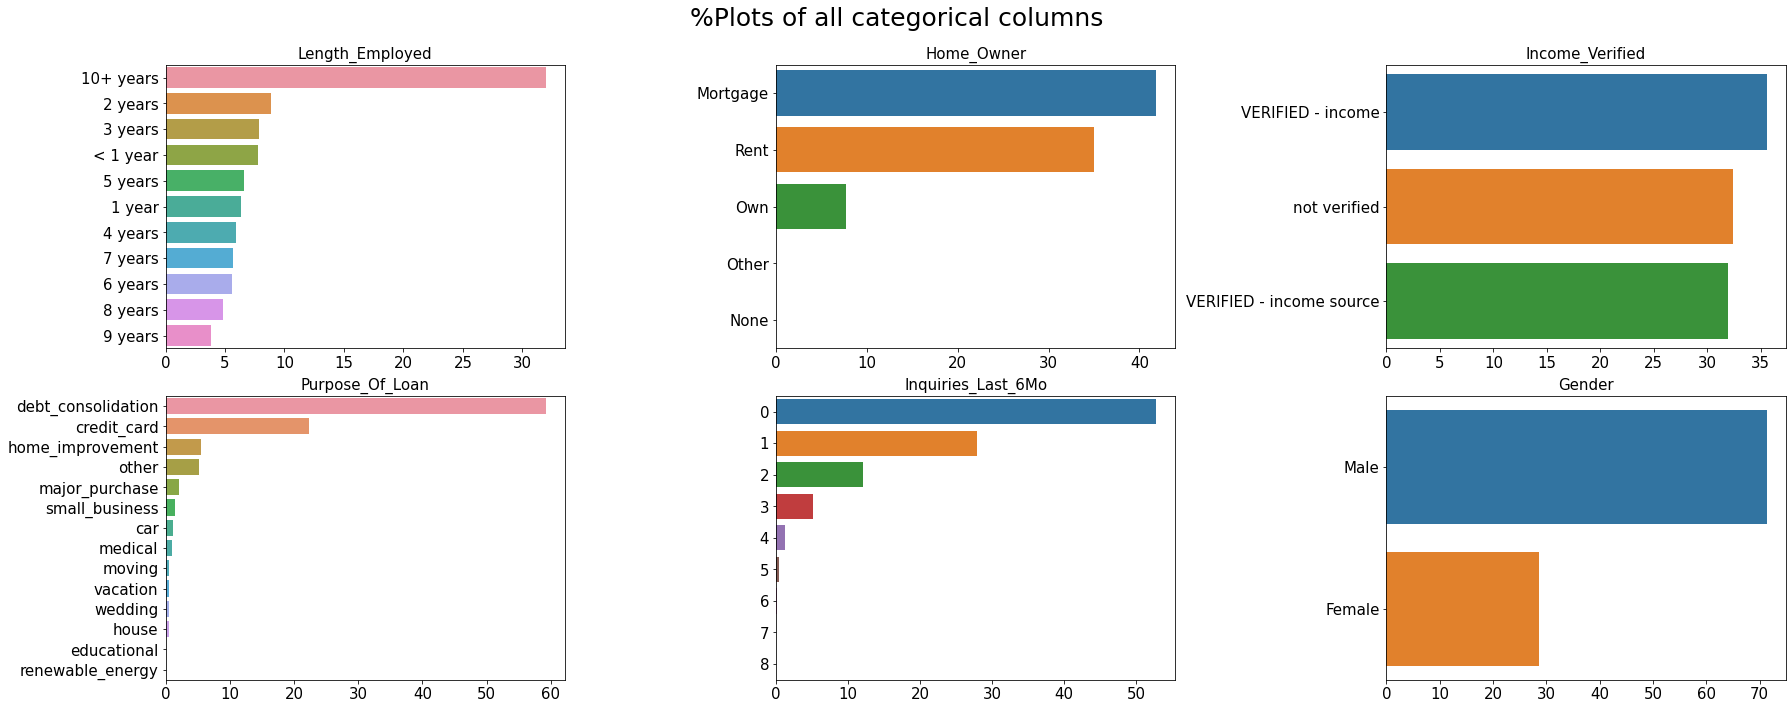

In [26]:
fig,ax = plt.subplots(nrows = 2,ncols=3,figsize = (25,10))
train_data1['Inquiries_Last_6Mo'] = train_data1['Inquiries_Last_6Mo'].astype('object') #Converting to object to get % count

for variables,plotsubs in zip(train_data1.select_dtypes('object'),ax.flatten()):
    counts_index,counts_values = train_data1[variables].value_counts().index,train_data1[variables].value_counts().values/len(train_data1)*100
    plotsubs.tick_params(labelsize = 15)
    plotsubs.set_title(variables,fontsize = 15)
    sns.barplot(counts_values,counts_index,ax = plotsubs,orient = 'h')
    plt.tight_layout()
    plt.subplots_adjust(top = 0.90)
    
fig.suptitle('%Plots of all categorical columns',fontsize = 25)
plt.show()

In [27]:
train_data1['Inquiries_Last_6Mo'] = train_data1['Inquiries_Last_6Mo'].astype(int) #Converting to object to get % count
train.groupby('Interest_Rate')['Inquiries_Last_6Mo'].mean()
#Higher number of inquiries tends to fetch higher rates of interest. But the disbalance in the proportion makes me
#doubt this result.

Interest_Rate
1    0.512246
2    0.703684
3    1.025600
Name: Inquiries_Last_6Mo, dtype: float64

###### Inferences

* Most of the distributions are positively skewed. Standardizing the data could help.
* Outliers were present and delt with in the dataset.
* While looking at the proportion plots we can see:
    - Income_Verified has 2 features as verified income source. This can be converted to one feature.
    - Home_Owner has the feature None. I feel this is an NaN field in this column and must be taken care of. This column can be changed to having loan or not.
    - Inquiries in last 6 Mo reduced due to removal of outliers. Rectified this by droping the column while calculating IQR above.
    - There are many categories for purpose of loan. This must be reduced and generalized.
    - Length_Employed features can also be bucketed to reduce the number of features.

# Feature Engineering (1)

* Creating a New column called 'Mortgage_on_house' based on 'Home_Owner' Column.
* Creating a column called closed_accounts = Total_accounts - Number_Open_Accounts.
* Binning Length Employed into 0-1,2-5,6-9,10+.
* Binning Purpose_Of_Loan as Assets, Liabilities and Other.
* Correcting the Income_Verified column to have only 2 values.

In [28]:
def Mortgage_on_house(x):
    if x=='Mortgage':
        return 'Yes'
    else:
        return 'No'
train_data1['Mortgage_on_house'] = train_data1['Home_Owner'].apply(Mortgage_on_house)

In [29]:
train_data1['Number_Closed_Accounts'] = train_data1['Total_Accounts'] - train_data1['Number_Open_Accounts']

In [30]:
def length_employed_bin(x):
    try:
        temp = int(x.replace('years','').replace('year','').replace('<','').strip().strip('+'))
        if temp in [1]:
            return '0-1'
        elif temp in [2,3,4,5]:
            return '2-5'
        elif temp in [6,7,8,9]:
            return '6-9'
        elif temp>=10:
            return '10+'
    except:
        return np.nan
train_data1['Length_Employed'] = train_data1['Length_Employed'].apply(length_employed_bin)

In [31]:
def purp_bin(x):
    assets = [ 'home_improvement','renewable_energy','house','educational','small_business']
    liabilities = ['car','debt_consolidation','credit_card']
    other = ['major_purchase', 'other', 'medical', 'moving','wedding','vacation']
    if x in assets:
        return 'asset'
    elif x in liabilities:
        return 'liability'
    elif x in other:
        return 'misc.'
train_data1['Purpose_Of_Loan'] = train_data1['Purpose_Of_Loan'].apply(purp_bin)

In [32]:
def inc_correct(x):
    if x == 'not verified':
        return 'not verified'
    else:
        return 'verified'
train_data1['Income_Verified'] = train_data1['Income_Verified'].apply(inc_correct)

# Bivariate Analysis

###### Checking relation between numerical columns using scatter plots

In [33]:
#Color map for the scatter plots
cmap = ['orange','r','g','b','k','m','violet','brown']

###### Loan_Amount_Requested

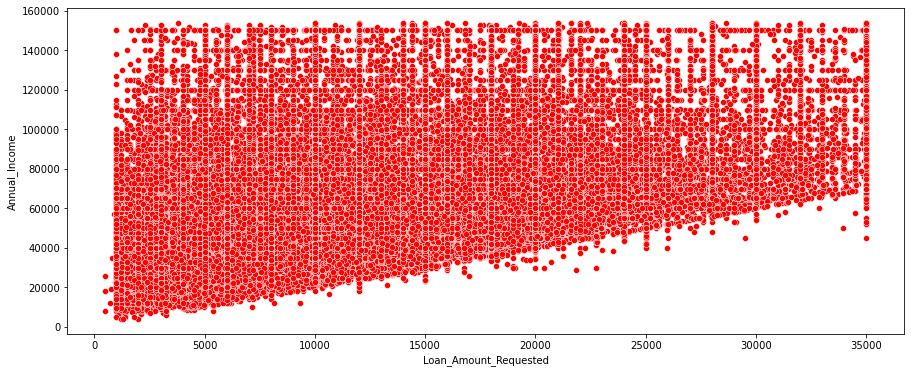

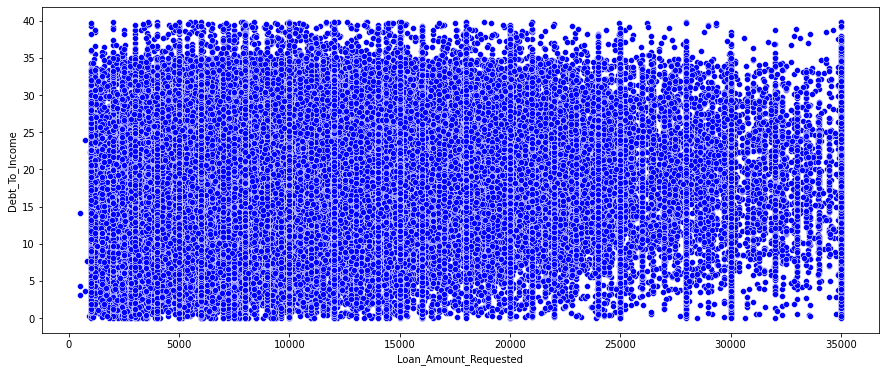

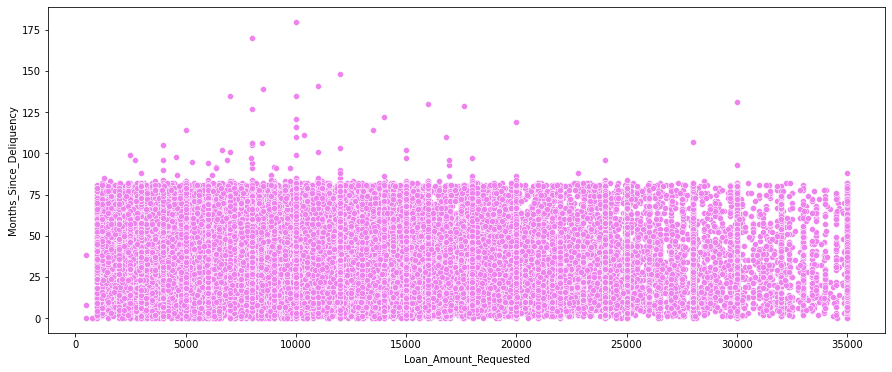

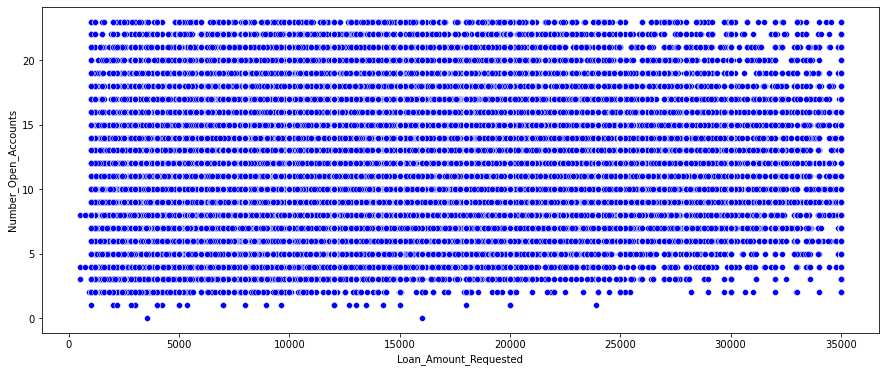

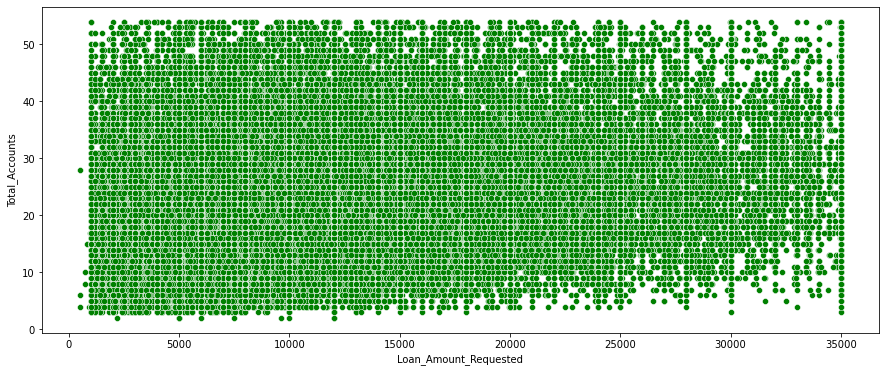

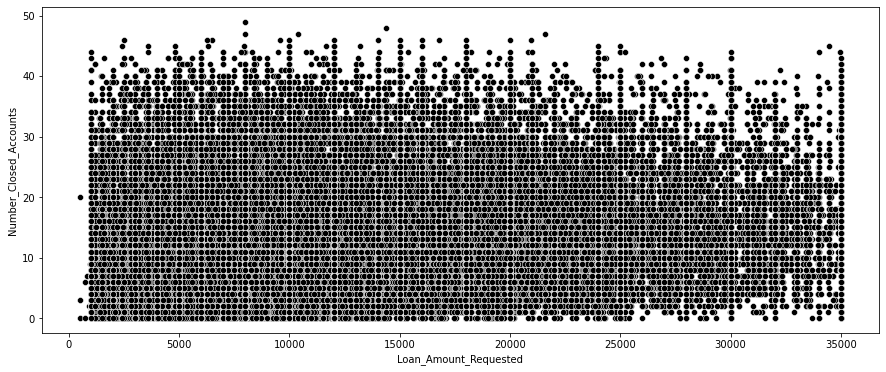

In [44]:
for i in train_data1.select_dtypes(np.number).drop(['Interest_Rate','Loan_Amount_Requested','Inquiries_Last_6Mo'],axis = 1).columns:
    plt.figure(figsize = (15,6))
    sns.scatterplot(train_data1['Loan_Amount_Requested'],train_data1[i],color = cmap[np.random.randint(len(cmap))])
    plt.show()
#Looking at the above plot, we can see a linear relationship though there are also generalised terms in the data.
#We could drop one of the above 2 columns or combine the 2 columns

In [197]:
train_data1[train_data1['Number_Open_Accounts']==0]
#Below table is interesting. Person is charged 3% interest rate even after not having any open lines of credit.

Loan_Amount_Requested Length_Employed Home_Owner  Annual_Income  \
8867                   16000             6-9       Rent            NaN   
72538                   3550             0-1        Own        43680.0   

      Income_Verified Purpose_Of_Loan  Debt_To_Income  Inquiries_Last_6Mo  \
8867         verified       liability             0.0                   0   
72538        verified       liability             0.0                   0   

       Months_Since_Deliquency  Number_Open_Accounts  Total_Accounts  Gender  \
8867                       NaN                     0              19  Female   
72538                      NaN                     0               3    Male   

       Interest_Rate Mortgage_on_house  Number_Closed_Accounts  
8867               3                No                      19  
72538              3                No                       3

###### Annual_Income

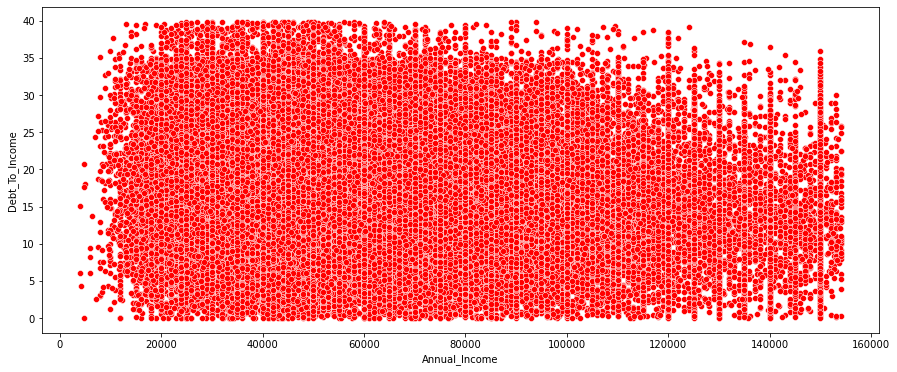

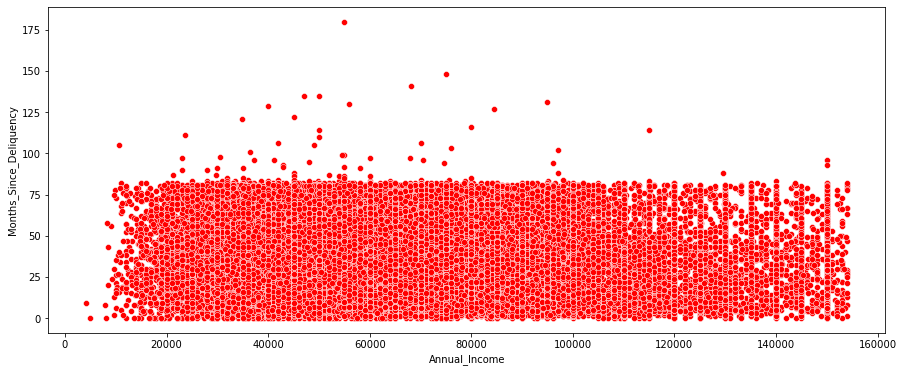

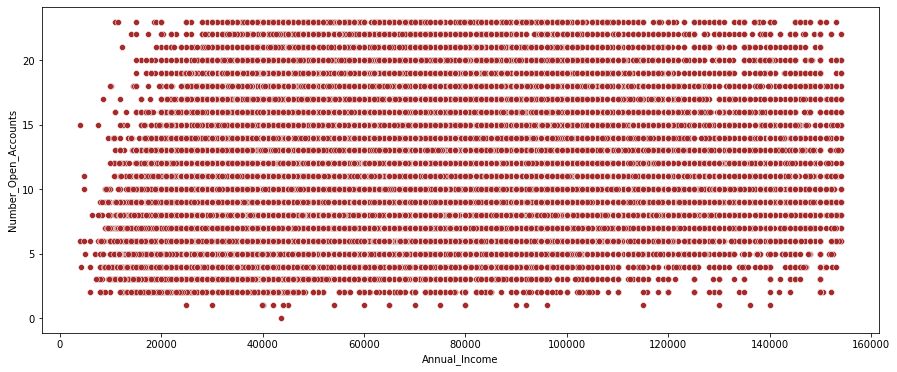

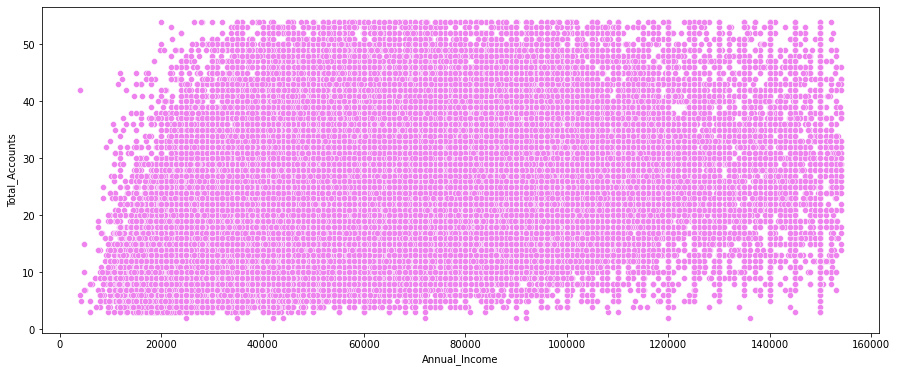

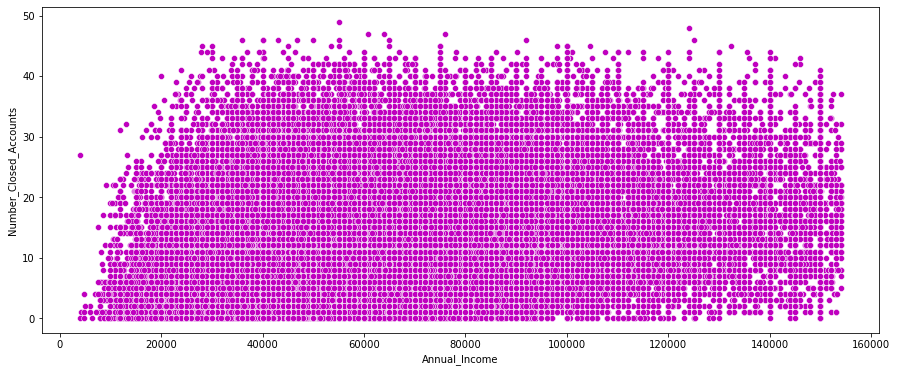

In [198]:
for i in train_data1.select_dtypes(np.number).drop(['Interest_Rate','Loan_Amount_Requested','Annual_Income','Inquiries_Last_6Mo'],axis = 1).columns:
    plt.figure(figsize = (15,6))
    sns.scatterplot(train_data1['Annual_Income'],train_data1[i],color = cmap[np.random.randint(len(cmap))])
    plt.show()

###### Debt_To_Income

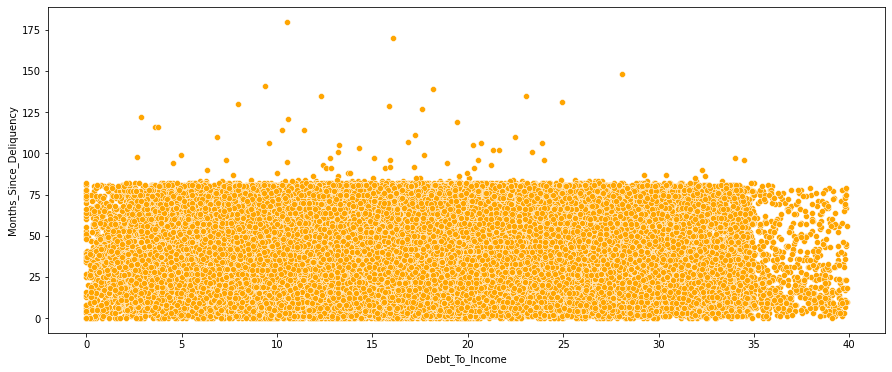

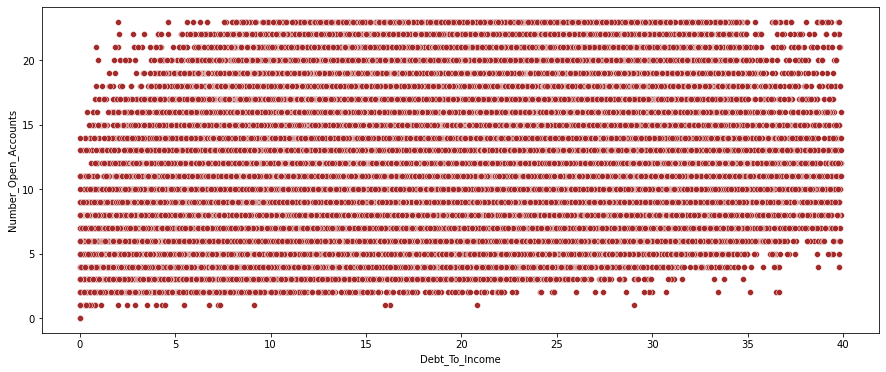

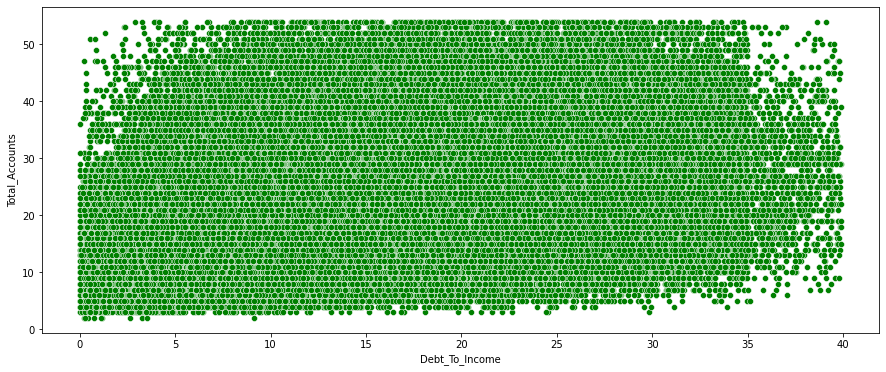

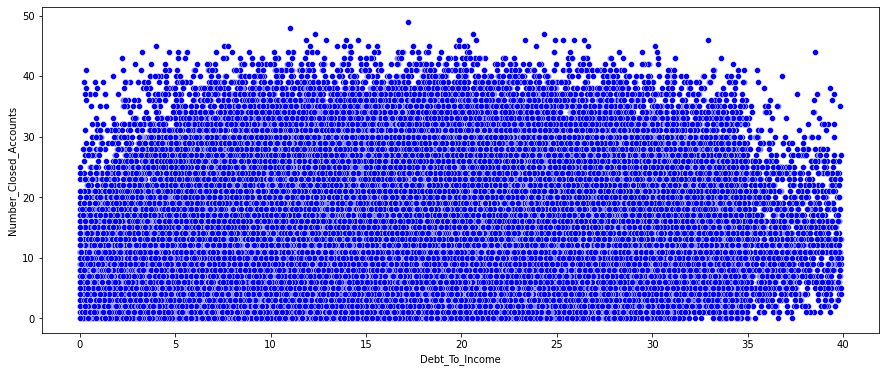

In [199]:
for i in train_data1.select_dtypes(np.number).drop(['Inquiries_Last_6Mo','Interest_Rate','Loan_Amount_Requested','Annual_Income','Debt_To_Income'],axis = 1).columns:
    plt.figure(figsize = (15,6))
    sns.scatterplot(train_data1['Debt_To_Income'],train_data1[i],color = cmap[np.random.randint(len(cmap))])
    plt.show()

###### Months_Since_Deliquency

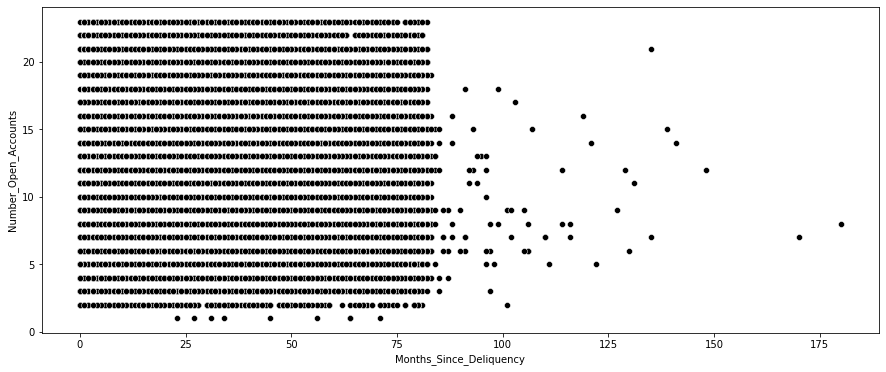

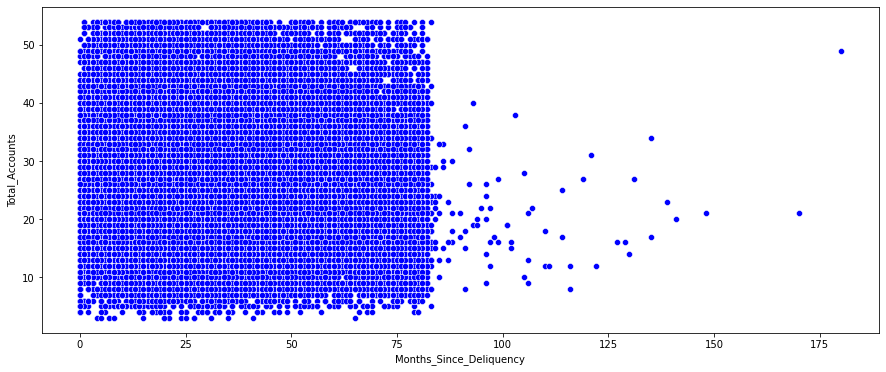

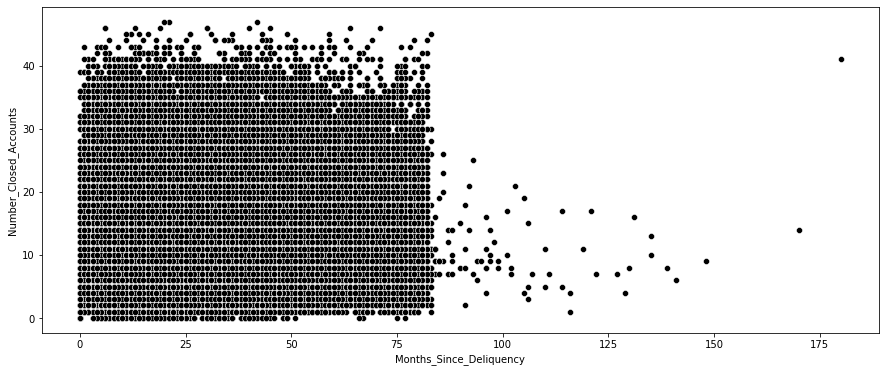

In [200]:
for i in train_data1.select_dtypes(np.number).drop(['Inquiries_Last_6Mo','Interest_Rate','Loan_Amount_Requested',
                                                    'Annual_Income','Debt_To_Income','Months_Since_Deliquency'],axis = 1).columns:
    plt.figure(figsize = (15,6))
    sns.scatterplot(train_data1['Months_Since_Deliquency'],train_data1[i],color = cmap[np.random.randint(len(cmap))])
    plt.show()

###### Number_Open_Accounts

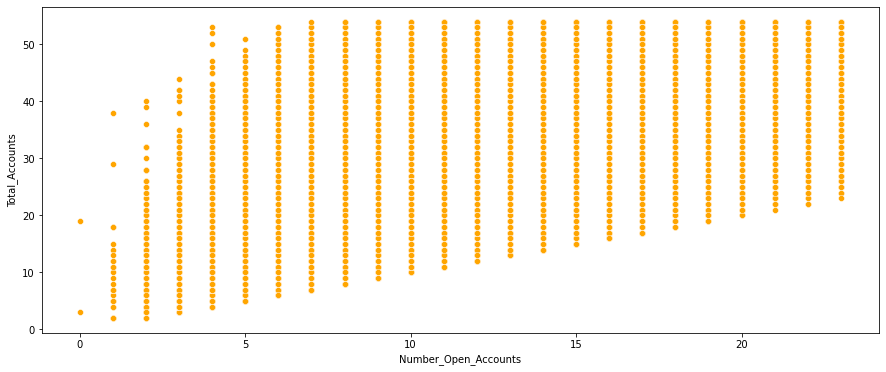

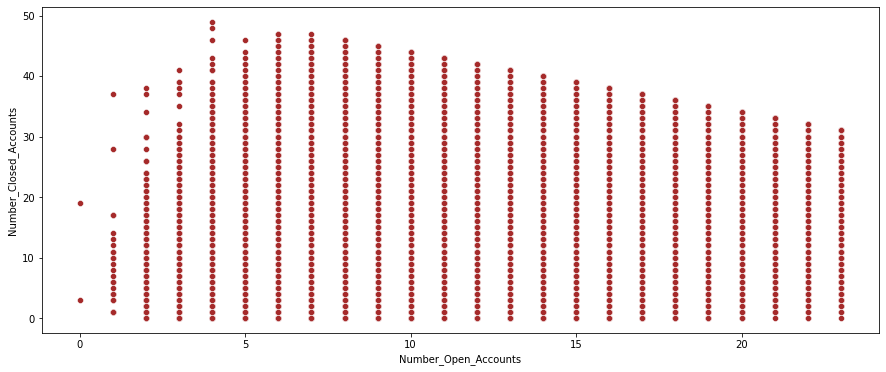

In [201]:
for i in train_data1.select_dtypes(np.number).drop(['Inquiries_Last_6Mo','Interest_Rate','Loan_Amount_Requested',
                                                    'Annual_Income','Debt_To_Income','Months_Since_Deliquency',
                                                   'Number_Open_Accounts'],axis = 1).columns:
    plt.figure(figsize = (15,6))
    sns.scatterplot(train_data1['Number_Open_Accounts'],train_data1[i],color = cmap[np.random.randint(len(cmap))])
    plt.show()

###### Total_Accounts

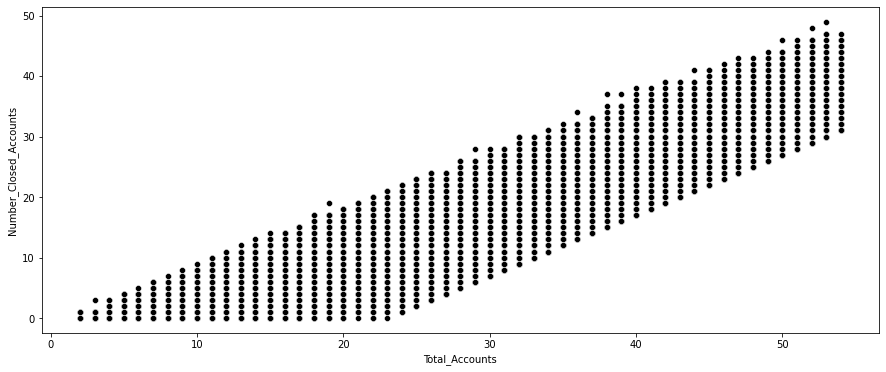

In [202]:
for i in train_data1.select_dtypes(np.number).drop(['Inquiries_Last_6Mo','Interest_Rate','Loan_Amount_Requested',
                                                    'Annual_Income','Debt_To_Income','Months_Since_Deliquency',
                                                   'Number_Open_Accounts','Total_Accounts'],axis = 1).columns:
    plt.figure(figsize = (15,6))
    sns.scatterplot(train_data1['Total_Accounts'],train_data1[i],color = cmap[np.random.randint(len(cmap))])
    plt.show()

###### Checking relation between target and numerical columns using boxplot

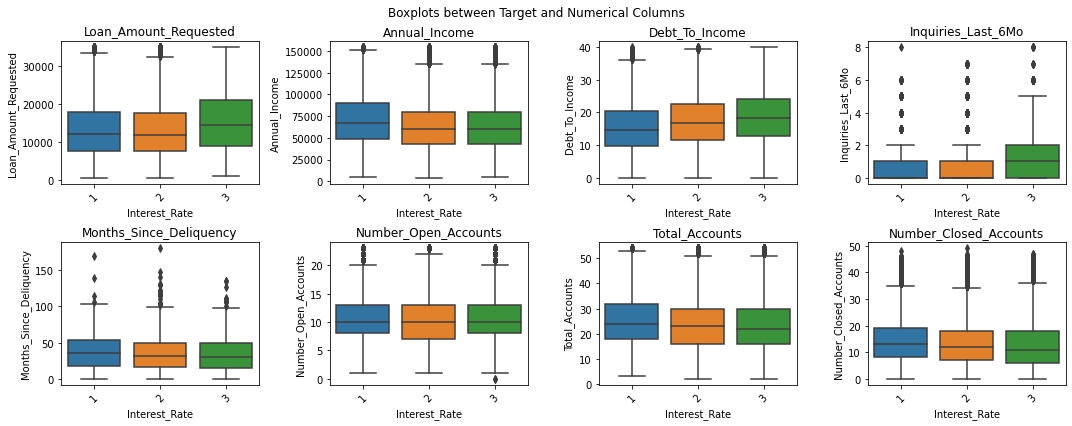

In [203]:
def boxplots(train_data1,target):
    fig,ax = plt.subplots(nrows = 2,ncols = 4,figsize = (15,6))
    for var,pltsubs in zip(train_data1.select_dtypes(np.number).drop('Interest_Rate',axis = 1).columns,ax.flatten()):
        pltsubs.set_title(var)
        pltsubs.tick_params('x',labelrotation = 45)
        sns.boxplot(train_data1[target],train_data1[var],ax = pltsubs)
        plt.tight_layout()
        plt.subplots_adjust(top = 0.9)

    fig.suptitle('Boxplots between Target and Numerical Columns')
    plt.show()
    
boxplots(train_data1,'Interest_Rate')

###### Length Employed

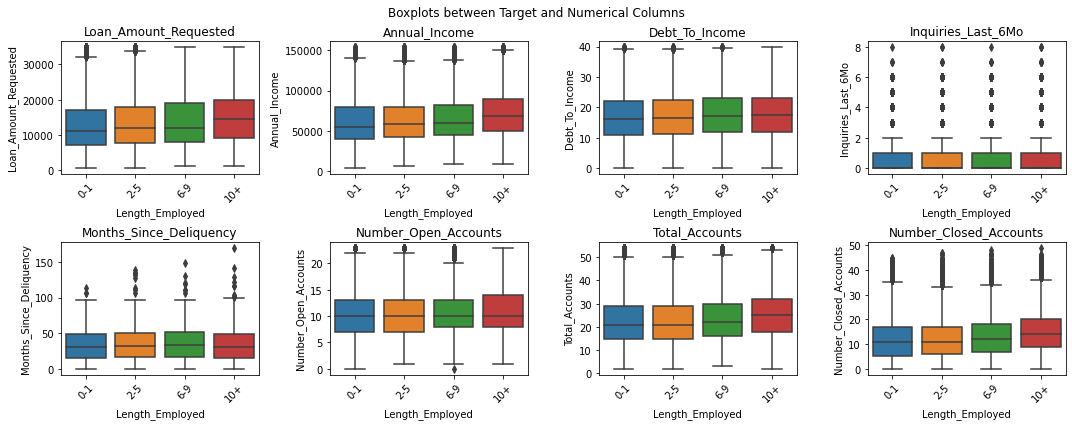

In [204]:
boxplots(train_data1,'Length_Employed')

###### Home_Owner

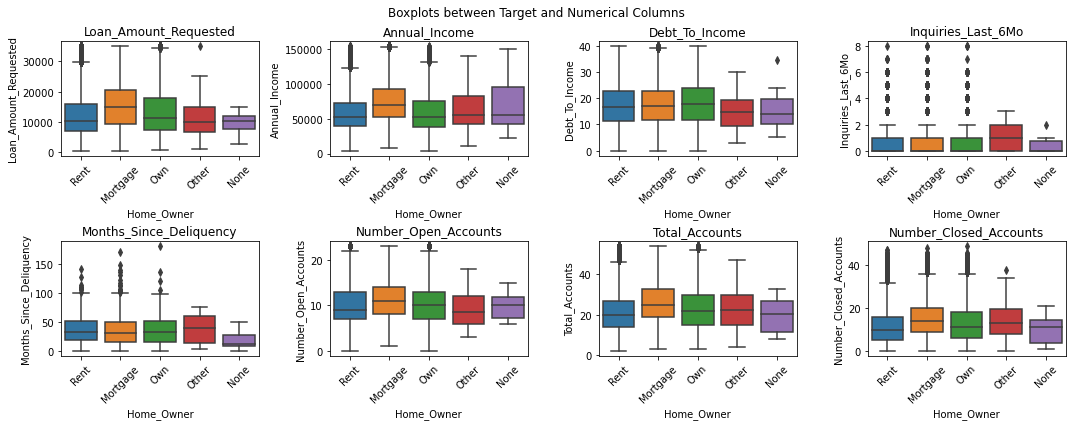

In [205]:
boxplots(train_data1,'Home_Owner')

###### Income_Verified 	

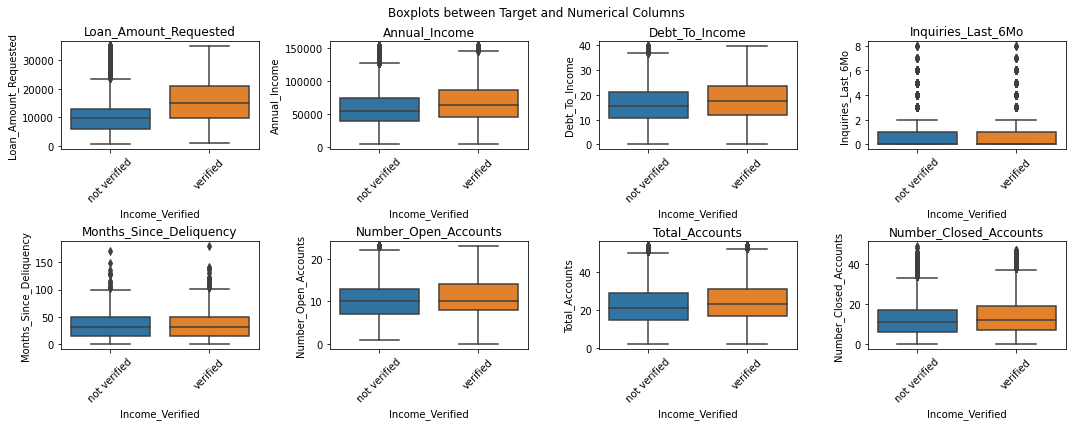

In [206]:
boxplots(train_data1,'Income_Verified')

###### Purpose_Of_Loan 	

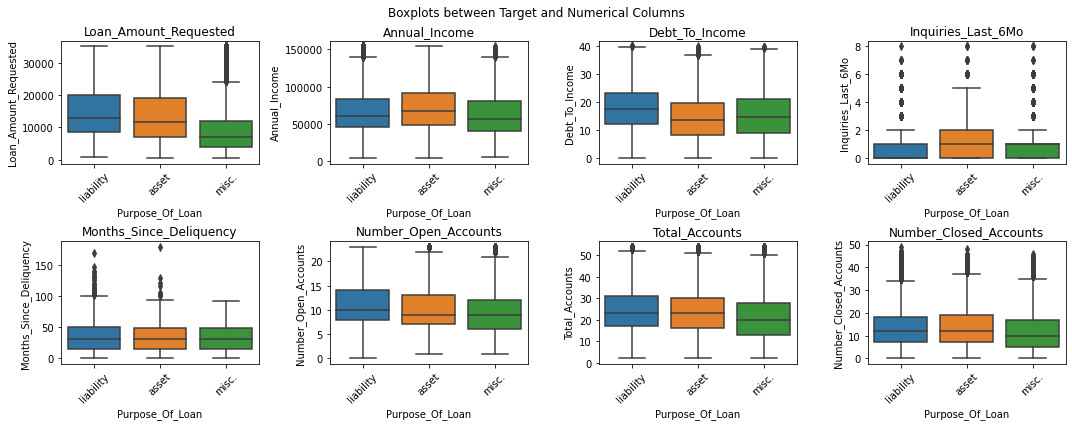

In [207]:
boxplots(train_data1,'Purpose_Of_Loan')

###### Gender 	

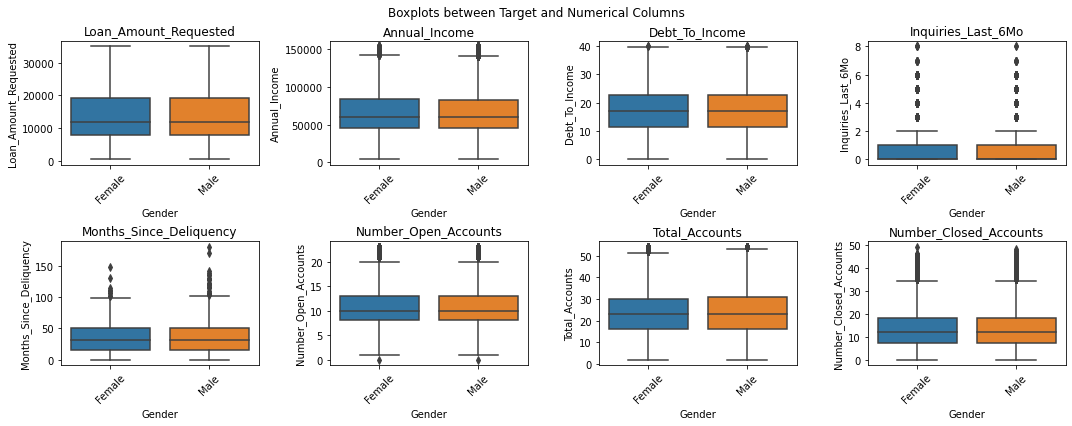

In [208]:
boxplots(train_data1,'Gender')

###### Mortgage_on_house

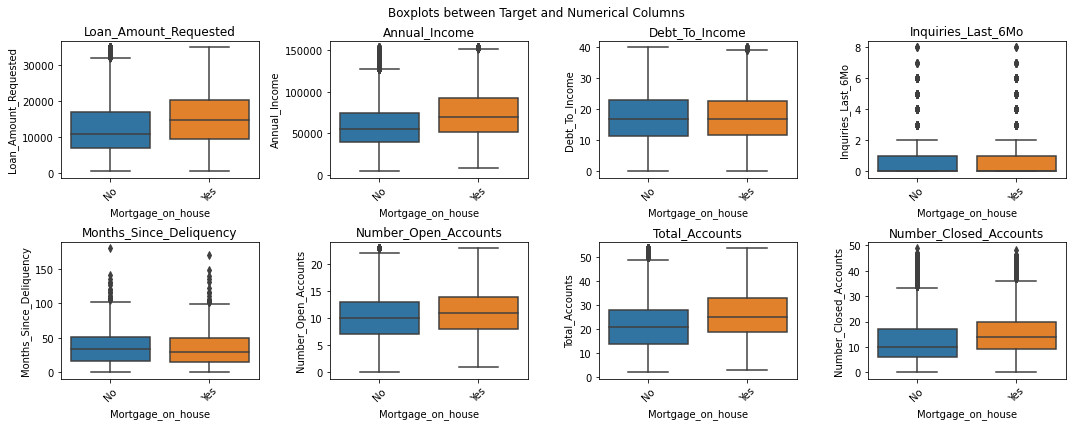

In [209]:
boxplots(train_data1,'Mortgage_on_house')

###### Bucketing Deliquency column since I suspect that the nan values mean that person has not been deliquent before which is good.

In [210]:
def deliquency(x):
    if x>150 and x<181:
        return 'good'
    elif x > 100 and x<150:
        return 'average'
    elif x <100 and x>50:
        return 'poor'
    elif x<50:
        return 'very poor'
    else:
        return 'good' #This will fill the nan as good since I am assuming that they have no past records of deliquency
train_data1['Months_Since_Deliquency'] = train_data1['Months_Since_Deliquency'].apply(deliquency)

###### Months_Since_Deliquency

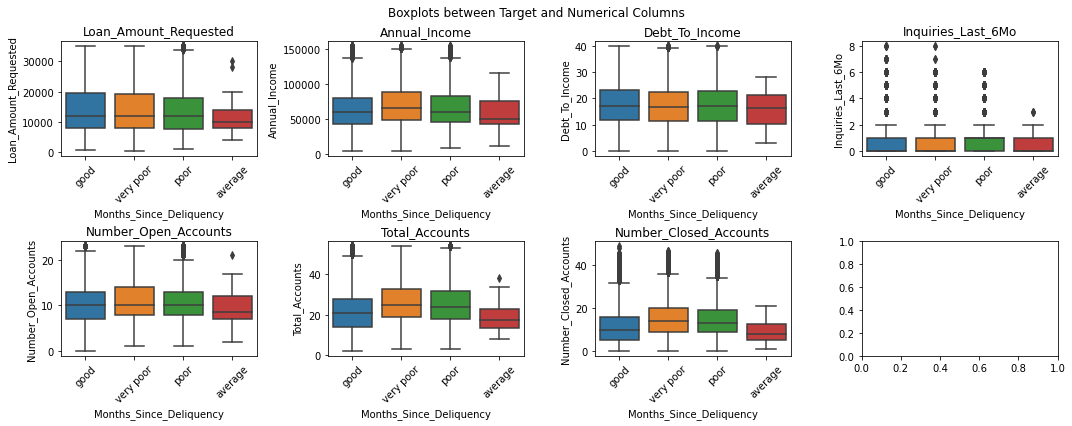

In [211]:
boxplots(train_data1,'Months_Since_Deliquency')

### Inferences

###### Scatter Plots
* There is a  linear relationship between Annual_Income and Loan_Amount_Requested though there are also generalised terms in the data.
* Closed,Open and Total Accounts are bound to be related to each other. We can drop any 2 of these columns

###### Again checking correlation with new created columns

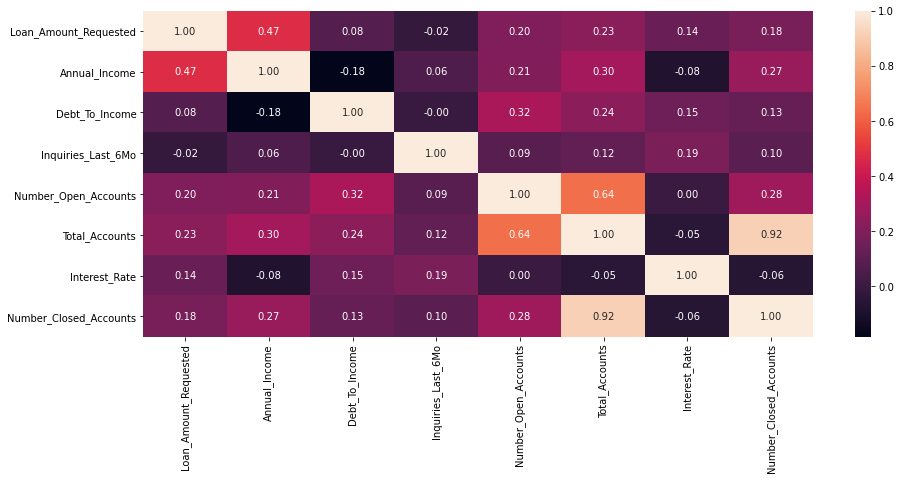

In [212]:
plt.figure(figsize = (15,6))
sns.heatmap(train_data1.corr(),annot = True,fmt = '.2f')
plt.show()

###### Total_Accounts can be dropped. Annual Income and loan amount requested can be combined since they show strong correlation(We will combine them after fixing null values). We can also drop Number_Open_Accounts since there is no correlation between this feature and Interest_Rate

In [213]:
train_data1 = train_data1.drop(['Total_Accounts','Number_Open_Accounts'],axis = 1)

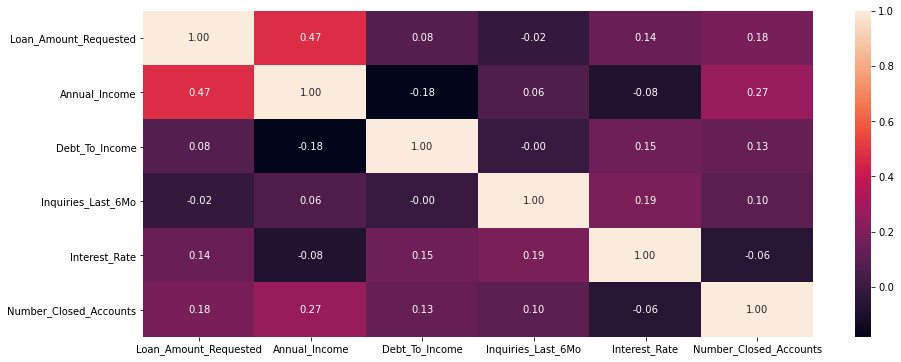

In [214]:
plt.figure(figsize = (15,6))
sns.heatmap(train_data1.corr(),annot = True,fmt = '.2f')
plt.show()

### Handling Null Values

In [215]:
train_data1.isna().sum()[train_data1.isna().sum()!=0]/len(train_data1)

Length_Employed    0.046601
Home_Owner         0.154552
Annual_Income      0.158136
dtype: float64

In [216]:
#KNNImputer can easily handle Length_Employed,Home_Owner,Annual_Income

###### Creating Categorical mappers

In [217]:
#Map to convert from categorical to numerical
cat_cols = train_data1.select_dtypes('object').columns
cat_cols_map = {}
for i in train_data1.select_dtypes('object'):
    temp = train_data1[i].dropna().unique()
    d = dict(zip(temp,list(range(len(temp)))))
    cat_cols_map.setdefault(i,d)

#To convert back to categorical
rev_cat_col_map = {}
for i in train_data1.select_dtypes('object'):
    temp = train_data1[i].dropna().unique()
    d = dict(zip(list(range(len(temp))),temp))
    rev_cat_col_map.setdefault(i,d)

In [218]:
train_data1.head()

Loan_Amount_Requested Length_Employed Home_Owner  Annual_Income  \
0                   7000             0-1       Rent        68000.0   
1                  30000             2-5   Mortgage            NaN   
2                  24725             6-9   Mortgage        75566.4   
3                  16000             0-1        NaN        56160.0   
4                  17000             6-9        Own        96000.0   

  Income_Verified Purpose_Of_Loan  Debt_To_Income  Inquiries_Last_6Mo  \
0    not verified       liability           18.37                   0   
1        verified       liability           14.93                   0   
2        verified       liability           15.88                   0   
3        verified       liability           14.34                   3   
4        verified       liability           22.17                   1   

  Months_Since_Deliquency  Gender  Interest_Rate Mortgage_on_house  \
0                    good  Female              1                No   
1               very poor  Female              3               Yes   
2                    good    Male              3               Yes   
3                    good    Male              3                No   
4                    good  Female              1                No   

   Number_Closed_Accounts  
0                       5  
1                      12  
2                       4  
3                       6  
4                      11

###### Converting Categorical to numerical

In [219]:
for i in cat_cols:
    train_data1[i] = train_data1[i].map(cat_cols_map[i])
train_data1.head()

Loan_Amount_Requested  Length_Employed  Home_Owner  Annual_Income  \
0                   7000              0.0         0.0        68000.0   
1                  30000              1.0         1.0            NaN   
2                  24725              2.0         1.0        75566.4   
3                  16000              0.0         NaN        56160.0   
4                  17000              2.0         2.0        96000.0   

   Income_Verified  Purpose_Of_Loan  Debt_To_Income  Inquiries_Last_6Mo  \
0                0                0           18.37                   0   
1                1                0           14.93                   0   
2                1                0           15.88                   0   
3                1                0           14.34                   3   
4                1                0           22.17                   1   

   Months_Since_Deliquency  Gender  Interest_Rate  Mortgage_on_house  \
0                        0       0              1                  0   
1                        1       0              3                  1   
2                        0       1              3                  1   
3                        0       1              3                  0   
4                        0       0              1                  0   

   Number_Closed_Accounts  
0                       5  
1                      12  
2                       4  
3                       6  
4                      11

###### Standardize the dataset since KNN is a distance based algorithm

In [220]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = train_data1.drop('Interest_Rate',axis = 1)
y = train_data1['Interest_Rate']
X_scaled = pd.DataFrame(ss.fit_transform(X),columns = X.columns)
X_scaled.head()

Loan_Amount_Requested  Length_Employed  Home_Owner  Annual_Income  \
0              -0.864241        -1.604832   -1.067651       0.067065   
1               2.000469        -0.677768    0.508030            NaN   
2               1.343454         0.249297    0.508030       0.326477   
3               0.256733        -1.604832         NaN      -0.338865   
4               0.381285         0.249297    2.083712       1.027036   

   Income_Verified  Purpose_Of_Loan  Debt_To_Income  Inquiries_Last_6Mo  \
0        -1.443255        -0.432107        0.141636           -0.748823   
1         0.692878        -0.432107       -0.298929           -0.748823   
2         0.692878        -0.432107       -0.177261           -0.748823   
3         0.692878        -0.432107       -0.374491            2.197256   
4         0.692878        -0.432107        0.628306            0.233203   

   Months_Since_Deliquency    Gender  Mortgage_on_house  \
0                -0.823326 -1.577339          -0.848340   
1                 0.634178 -1.577339           1.178772   
2                -0.823326  0.633979           1.178772   
3                -0.823326  0.633979          -0.848340   
4                -0.823326 -1.577339          -0.848340   

   Number_Closed_Accounts  
0               -0.998586  
1               -0.145137  
2               -1.120507  
3               -0.876664  
4               -0.267058

###### Applying KNNImputer

In [221]:
from sklearn.impute import KNNImputer
import time
start = time.time()
knn_impute = KNNImputer(n_neighbors = 10)
no_na = knn_impute.fit_transform(X_scaled,y)
end = time.time()
print('Execution Time:',(end-start)/60)

Execution Time: 13.320703887939453


###### Unscale

In [222]:
X_unscaled = pd.DataFrame(ss.inverse_transform(no_na),columns = X.columns).apply(round)
X_unscaled.head()

Loan_Amount_Requested  Length_Employed  Home_Owner  Annual_Income  \
0                 7000.0              0.0         0.0        68000.0   
1                30000.0              1.0         1.0       100895.0   
2                24725.0              2.0         1.0        75566.0   
3                16000.0              0.0         0.0        56160.0   
4                17000.0              2.0         2.0        96000.0   

   Income_Verified  Purpose_Of_Loan  Debt_To_Income  Inquiries_Last_6Mo  \
0              0.0              0.0            18.0                 0.0   
1              1.0              0.0            15.0                 0.0   
2              1.0              0.0            16.0                 0.0   
3              1.0              0.0            14.0                 3.0   
4              1.0              0.0            22.0                 1.0   

   Months_Since_Deliquency  Gender  Mortgage_on_house  Number_Closed_Accounts  
0                      0.0     0.0                0.0                     5.0  
1                      1.0     0.0                1.0                    12.0  
2                      0.0     1.0                1.0                     4.0  
3                      0.0     1.0                0.0                     6.0  
4                      0.0     0.0                0.0                    11.0

###### Converting Numerical to categorical

In [223]:
for i in cat_cols:
    X_unscaled[i] = X_unscaled[i].map(rev_cat_col_map[i])
X_unscaled.head()

Loan_Amount_Requested Length_Employed Home_Owner  Annual_Income  \
0                 7000.0             0-1       Rent        68000.0   
1                30000.0             2-5   Mortgage       100895.0   
2                24725.0             6-9   Mortgage        75566.0   
3                16000.0             0-1       Rent        56160.0   
4                17000.0             6-9        Own        96000.0   

  Income_Verified Purpose_Of_Loan  Debt_To_Income  Inquiries_Last_6Mo  \
0    not verified       liability            18.0                 0.0   
1        verified       liability            15.0                 0.0   
2        verified       liability            16.0                 0.0   
3        verified       liability            14.0                 3.0   
4        verified       liability            22.0                 1.0   

  Months_Since_Deliquency  Gender Mortgage_on_house  Number_Closed_Accounts  
0                    good  Female                No                     5.0  
1               very poor  Female               Yes                    12.0  
2                    good    Male               Yes                     4.0  
3                    good    Male                No                     6.0  
4                    good  Female                No                    11.0

###### Checking correlation to see whether nature of data has changed or not.

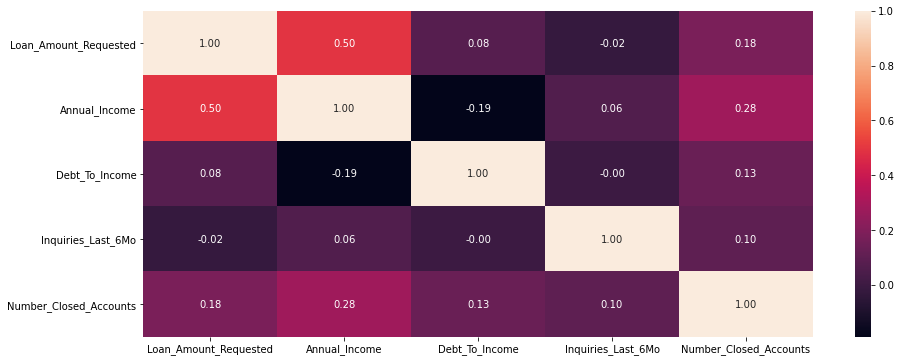

In [224]:
plt.figure(figsize = (15,6))
sns.heatmap(X_unscaled.corr(),annot = True,fmt = '.2f')
plt.show()

###### Looking at the above correlations we can see that the nature of the data has not changed due to KNNImputer

In [225]:
X_unscaled['Annual_Income_Amt_Req'] = X_unscaled['Annual_Income']/X_unscaled['Loan_Amount_Requested']
X_unscaled = X_unscaled.drop(['Annual_Income','Loan_Amount_Requested'],axis = 1)

In [226]:
# pd.concat((X_unscaled,y.reset_index(drop = True)),axis = 1).to_csv('Data/21-03-2021_Data_filled.csv',index = False)

# Statistical Analysis

In [60]:
df = pd.read_csv('Data/21-03-2021_Data_filled.csv')#Saving the file

In [228]:
df.select_dtypes(np.number).columns

Index(['Debt_To_Income', 'Inquiries_Last_6Mo', 'Number_Closed_Accounts',
       'Annual_Income_Amt_Req', 'Interest_Rate'],
      dtype='object')

##### Anova

In [48]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
model = ols("Interest_Rate~Debt_To_Income+Inquiries_Last_6Mo+Number_Closed_Accounts+Annual_Income_Amt_Req",df).fit()
sm.stats.anova_lm(model)

df        sum_sq      mean_sq            F  \
Debt_To_Income               1.0   1909.781485  1909.781485  3807.958980   
Inquiries_Last_6Mo           1.0   2938.724246  2938.724246  5859.592563   
Number_Closed_Accounts       1.0    855.668990   855.668990  1706.138865   
Annual_Income_Amt_Req        1.0    391.700458   391.700458   781.020912   
Residual                153167.0  76816.872816     0.501524          NaN   

                               PR(>F)  
Debt_To_Income           0.000000e+00  
Inquiries_Last_6Mo       0.000000e+00  
Number_Closed_Accounts   0.000000e+00  
Annual_Income_Amt_Req   1.952344e-171  
Residual                          NaN

In [49]:
sm.stats.anova_lm(model)['PR(>F)']>0.05

Debt_To_Income            False
Inquiries_Last_6Mo        False
Number_Closed_Accounts    False
Annual_Income_Amt_Req     False
Residual                  False
Name: PR(>F), dtype: bool

###### Pairwise Tukey HSD

In [50]:
def tukey(data_for_stats,col):
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    print("\033[1m"+'Tukey HSD test for {} is:'.format(col)+"\033[0;0m")
    return print(pairwise_tukeyhsd(data_for_stats[col],data_for_stats['Interest_Rate'])),print('*'*80)

In [51]:
for i in df.select_dtypes(np.number).drop('Interest_Rate',axis = 1).columns:
    tukey(df,i)

Tukey HSD test for Debt_To_Income is:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     1      2   2.0008 0.001 1.8763 2.1253   True
     1      3   3.3129 0.001 3.1848  3.441   True
     2      3   1.3122 0.001 1.2082 1.4161   True
-------------------------------------------------
********************************************************************************
Tukey HSD test for Inquiries_Last_6Mo is:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
     1      2   0.1873 0.001 0.1712 0.2034   True
     1      3   0.5032 0.001 0.4867 0.5198   True
     2      3   0.3159 0.001 0.3025 0.3294   True
-------------------------------------------------
********************************************************************************
Tukey HSD test for Number_Closed_Accounts is:
Multiple

###### As can be observed in the above Tukey Test, we can see that all our numerical columns are having a significant difference in mean for each of the interest rate categories.

### Chi Square Test

In [52]:
def chi(data_for_stats):
    from scipy.stats import chi2_contingency
    cat_cols = data_for_stats.select_dtypes('object').columns
    pval = []
    for i in cat_cols:
        cross_tabbed = pd.crosstab(data_for_stats[i],data_for_stats['Interest_Rate'])
        fstat,pvalue,df,freq = chi2_contingency(cross_tabbed)
        pval.append(pvalue)
    chi_out = pd.DataFrame({'Feature':cat_cols,'chi_pvalue':pval})
    return chi_out
chi(df)[chi(df)['chi_pvalue']>0.05]

Feature  chi_pvalue
5  Gender     0.12092

###### Gender is the only ccategorical column that is not playing a significant role in determining Interest Rate. This column can be dropped

### TTest Independent

In [53]:
#Gender and income_verified seem to have only 2 categories each. These features can be compared using ttest.

#Creating a function for independent ttest
def ttest_calc(f_data,col_name,col_name1):
    print()
    ttest_pos_rec = f_data[f_data[col_name] == f_data[col_name].unique()[0]][col_name1]
    ttest_pos_nrec = f_data[f_data[col_name] == f_data[col_name].unique()[1]][col_name1]
    teststat,pval = stats.ttest_ind(ttest_pos_rec,ttest_pos_nrec)
    if pval<0.05:
        print("T-test for {} is having:\np-value: {}\nWe can conclude that {} feature has a relation with {}\n".format(col_name,pval,col_name,col_name1))
    else:
        print("T-test for {} is having:\np-value: {}\nWe can conclude that {} feature has no relation with {}.\n".format(col_name,pval,col_name,col_name1))
    print('*'*85)
    print()

In [54]:
from scipy.stats import stats
print('*'*85)
for j in ['Gender','Income_Verified','Mortgage_on_house']:
    for i in df.select_dtypes(np.number).iloc[:,:-1].columns:
        ttest_calc(df,j,i)

*************************************************************************************

T-test for Gender is having:
p-value: 0.7216434018492162
We can conclude that Gender feature has no relation with Debt_To_Income.

*************************************************************************************


T-test for Gender is having:
p-value: 0.9616222412802733
We can conclude that Gender feature has no relation with Inquiries_Last_6Mo.

*************************************************************************************


T-test for Gender is having:
p-value: 0.37426345388722015
We can conclude that Gender feature has no relation with Number_Closed_Accounts.

*************************************************************************************


T-test for Gender is having:
p-value: 0.19090385210456942
We can conclude that Gender feature has no relation with Annual_Income_Amt_Req.

*************************************************************************************


T-test for Incom

## Inferences

* Anova Test suggests that all the numerical columns present are tending to show differences in mean for the interest rate categories. The same is confirmed by the tukey hsd test.
* The chi square test tells us that gender is not having any significant impact in predicting loan interest rates.
* The ttest also confirms the same about the gender column and that it is not related to any of the columns in this dataset.


### Preparing the dataset for model building process

In [55]:
#Drop home_owner and gender column since we have already created a mortgage_on_house column from this feature and 
#gender is not playing any role in predicting rate of interest according to the statistical tests.
final_d = df.drop(['Home_Owner','Gender'],axis = 1)

In [56]:
#We can manually convert Months_Since_Deliquency since it is an ordinal column according to me.
deli_map = dict(zip(df['Months_Since_Deliquency'].unique(),[3,0,1,2]))
final_d['Months_Since_Deliquency'] = final_d['Months_Since_Deliquency'].map(deli_map)

In [57]:
#One Hot Encoding rest of the data
final_df = pd.get_dummies(final_d,drop_first = True)

In [58]:
#X y split
X = final_df.drop('Interest_Rate',axis = 1)
y = final_df['Interest_Rate']
X.head()

Debt_To_Income  Inquiries_Last_6Mo  Months_Since_Deliquency  \
0            18.0                 0.0                        3   
1            15.0                 0.0                        0   
2            16.0                 0.0                        3   
3            14.0                 3.0                        3   
4            22.0                 1.0                        3   

   Number_Closed_Accounts  Annual_Income_Amt_Req  Length_Employed_10+  \
0                     5.0               9.714286                    0   
1                    12.0               3.363167                    0   
2                     4.0               3.056259                    0   
3                     6.0               3.510000                    0   
4                    11.0               5.647059                    0   

   Length_Employed_2-5  Length_Employed_6-9  Income_Verified_verified  \
0                    0                    0                         0   
1                    1                    0                         1   
2                    0                    1                         1   
3                    0                    0                         1   
4                    0                    1                         1   

   Purpose_Of_Loan_liability  Purpose_Of_Loan_misc.  Mortgage_on_house_Yes  
0                          1                      0                      0  
1                          1                      0                      1  
2                          1                      0                      1  
3                          1                      0                      0  
4                          1                      0                      0

In [59]:
#Standardized X y split
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X),columns = X.columns)
X_scaled.head()

Debt_To_Income  Inquiries_Last_6Mo  Months_Since_Deliquency  \
0        0.094193           -0.748823                 0.889430   
1       -0.289757           -0.748823                -1.252833   
2       -0.161774           -0.748823                 0.889430   
3       -0.417740            2.197256                 0.889430   
4        0.606126            0.233203                 0.889430   

   Number_Closed_Accounts  Annual_Income_Amt_Req  Length_Employed_10+  \
0               -0.998586               0.524483            -0.686838   
1               -0.145137              -0.515396            -0.686838   
2               -1.120507              -0.565647            -0.686838   
3               -0.876664              -0.491355            -0.686838   
4               -0.267058              -0.141451            -0.686838   

   Length_Employed_2-5  Length_Employed_6-9  Income_Verified_verified  \
0            -0.665055            -0.548615                 -1.443255   
1             1.503636            -0.548615                  0.692878   
2            -0.665055             1.822772                  0.692878   
3            -0.665055            -0.548615                  0.692878   
4            -0.665055             1.822772                  0.692878   

   Purpose_Of_Loan_liability  Purpose_Of_Loan_misc.  Mortgage_on_house_Yes  
0                   0.457469               -0.32996              -0.848340  
1                   0.457469               -0.32996               1.178772  
2                   0.457469               -0.32996               1.178772  
3                   0.457469               -0.32996              -0.848340  
4                   0.457469               -0.32996              -0.848340

### Train test split

In [60]:
#train test split for normal data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 6)

In [61]:
#train test split for standardized data
from sklearn.model_selection import train_test_split
X1_train,X1_test,y1_train,y1_test = train_test_split(X_scaled,y,test_size = 0.1,random_state = 6)

### Model Building

###### Building the following Models:
* LogisticRegression
* DecisionTreeClassifier
* RandomForestClassifier

In [62]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X1_train,y1_train)
ypred = lr.predict(X1_test)

In [63]:
from sklearn.metrics import classification_report
print(classification_report(ypred,y1_test))

              precision    recall  f1-score   support

           1       0.15      0.54      0.24       878
           2       0.67      0.48      0.56      9440
           3       0.48      0.54      0.51      5000

    accuracy                           0.50     15318
   macro avg       0.44      0.52      0.44     15318
weighted avg       0.58      0.50      0.52     15318



###### Applying SMOTE to increase data balance

In [64]:
from imblearn.over_sampling import SMOTE
s = SMOTE()
X_train_smt,y_train_smt = s.fit_resample(X_train,y_train)
X_test_smt,y_test_smt = s.fit_resample(X_test,y_test)

#### Retrying with Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_smt,y_train_smt)
ypred_smt = lr.predict(X_test) #Predicting using the original test set.

In [66]:
from sklearn.metrics import classification_report
print(classification_report(ypred_smt,y_test))

              precision    recall  f1-score   support

           1       0.52      0.35      0.42      4492
           2       0.33      0.48      0.39      4588
           3       0.58      0.52      0.55      6238

    accuracy                           0.46     15318
   macro avg       0.48      0.45      0.45     15318
weighted avg       0.49      0.46      0.46     15318



###### Performance of our model has gone down on testing with the original test set. however if we notice, the f1-score of class 1 and class 3 has increased but of class 2 has decreased. This is because SMOTE has changed some of the class 2 samples into 3 and 1 samples.

In [67]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_smt,y_train_smt)
ypred_smt = lr.predict(X_test_smt) #Predicting using the SMOTE test set.

In [68]:
from sklearn.metrics import classification_report
print(classification_report(ypred_smt,y_test_smt))

              precision    recall  f1-score   support

           1       0.65      0.57      0.61      7613
           2       0.33      0.43      0.37      5176
           3       0.57      0.53      0.55      7284

    accuracy                           0.52     20073
   macro avg       0.52      0.51      0.51     20073
weighted avg       0.54      0.52      0.53     20073



###### On resampling both the train and test set we get slightly better accuracy of 0.52. However we cannot resample the test set since this would mean us changing the real world data.

###### Creating a base  function for all models

In [69]:
def model_function(model,X_train,X_test,y_train,y_test):
    #Fitting the model
    model = model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('*'*95)
    print("\n"+"\033[1m"+'Model Report for '+str(model)+"\033[0;0m"+"\n")
    print('*'*95)

    #Performance metrics
    from sklearn.metrics import classification_report
    print(classification_report(y_test,y_pred))

    #Confusion_Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize = (15,6))
    sns.heatmap(cm,annot = True,fmt = '.2f')
    plt.title('Confusion Matrix')
    plt.xticks([0.5,1.5,2.5],[1,2,3])
    plt.yticks([0.5,1.5,2.5],[1,2,3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def grid_search(estimator,params,X_train,y_train,cv=5,v=0):
    from sklearn.model_selection import GridSearchCV
    grid = GridSearchCV(estimator,params,scoring = 'roc_auc',n_jobs = -1,cv = cv,verbose = v)
    grid.fit(X_train,y_train)
    return grid.best_params_

### DecisionTreeClassifier

***********************************************************************************************

Model Report for DecisionTreeClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.30      0.31      0.30      3041
           2       0.45      0.44      0.45      6691
           3       0.45      0.45      0.45      5586

    accuracy                           0.42     15318
   macro avg       0.40      0.40      0.40     15318
weighted avg       0.42      0.42      0.42     15318



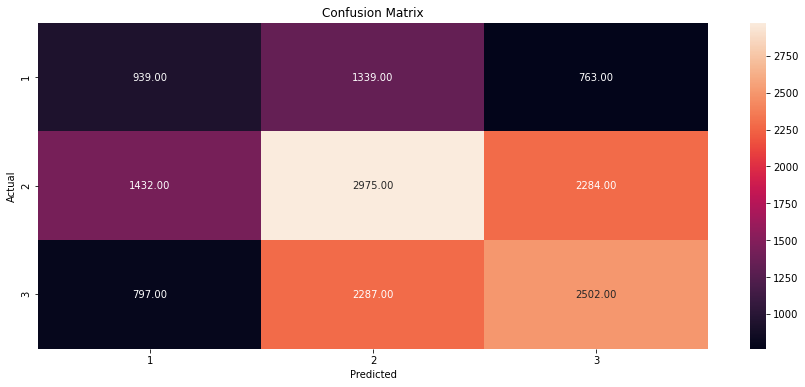

In [70]:
from sklearn.tree import DecisionTreeClassifier
dtf = DecisionTreeClassifier()
model_function(dtf,X_train,X_test,y_train,y_test)

###### Hyperparameter Tuning

In [71]:
params = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10],
              "max_depth": [5,10,20,50,100,150]
              }
params = grid_search(dtf,params,X_train,y_train,cv = 5)
params

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

In [72]:
# params = {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

***********************************************************************************************

Model Report for DecisionTreeClassifier(max_depth=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.57      0.07      0.12      3041
           2       0.48      0.70      0.57      6691
           3       0.54      0.51      0.53      5586

    accuracy                           0.50     15318
   macro avg       0.53      0.42      0.40     15318
weighted avg       0.52      0.50      0.46     15318



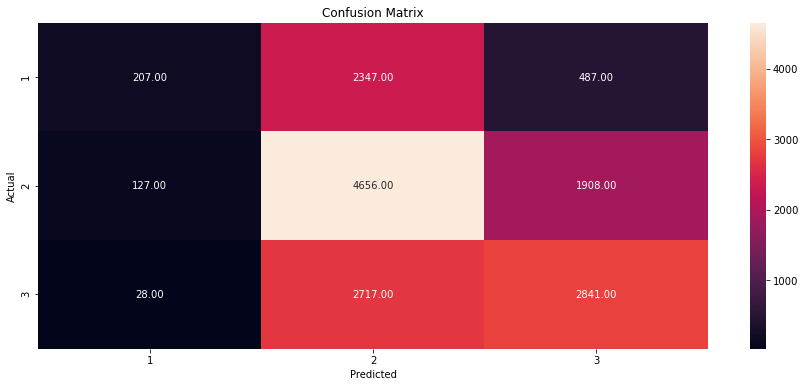

In [73]:
#Trying on the original train test data
dtf = DecisionTreeClassifier(criterion = params['criterion'],
                             max_depth = params['max_depth'],
                             min_samples_split = params['min_samples_split'])
model_function(dtf,X_train,X_test,y_train,y_test)
# We see an 8% score improvement after hyperparameter tuning. Recall has increased for interest rate 2 but there is
# a big fall in recall and f1-score for interest rate 1.

***********************************************************************************************

Model Report for DecisionTreeClassifier(max_depth=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.33      0.53      0.41      3041
           2       0.49      0.18      0.27      6691
           3       0.49      0.69      0.57      5586

    accuracy                           0.44     15318
   macro avg       0.44      0.47      0.42     15318
weighted avg       0.46      0.44      0.41     15318



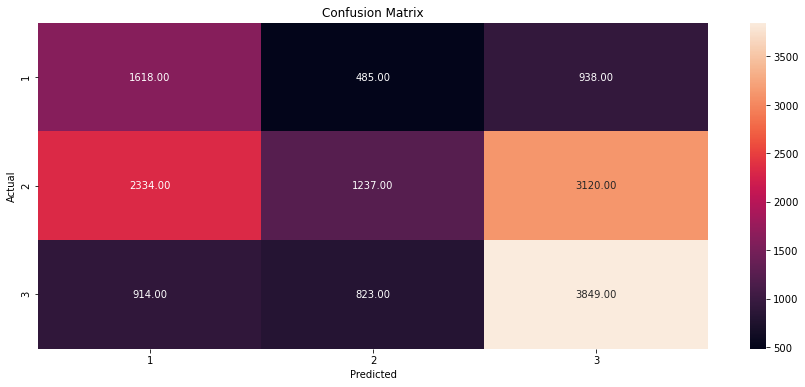

In [74]:
#Trying on the SMOTE resampled dataset with original test set
model_function(dtf,X_train_smt,X_test,y_train_smt,y_test)

###### There is slight improvement in the f1score of the minority classes however there is a decrease in f1score in the majority class

***********************************************************************************************

Model Report for DecisionTreeClassifier(max_depth=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.55      0.65      0.59      6691
           2       0.40      0.18      0.25      6691
           3       0.49      0.66      0.56      6691

    accuracy                           0.50     20073
   macro avg       0.48      0.50      0.47     20073
weighted avg       0.48      0.50      0.47     20073



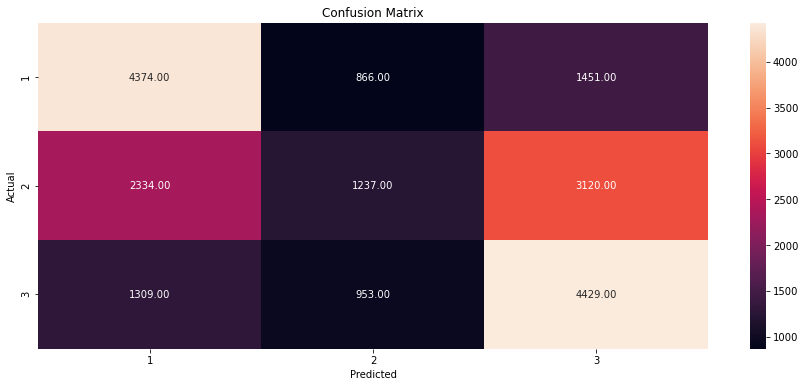

In [75]:
#Trying on the SMOTE resampled dataset with SMOTE test set
model_function(dtf,X_train_smt,X_test_smt,y_train_smt,y_test_smt)

###### On the SMOTE train and test sets we get a better overall f1-score.

### RandomForestClassifier

***********************************************************************************************

Model Report for RandomForestClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.38      0.27      0.31      3041
           2       0.47      0.53      0.50      6691
           3       0.50      0.51      0.50      5586

    accuracy                           0.47     15318
   macro avg       0.45      0.44      0.44     15318
weighted avg       0.46      0.47      0.46     15318



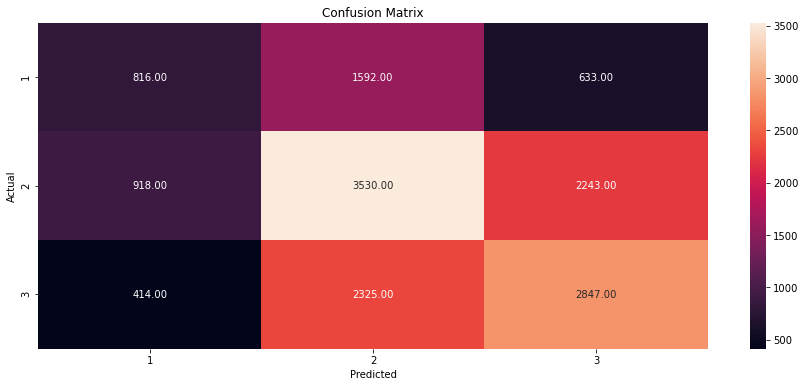

In [76]:
#Base model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
model_function(rfc,X_train,X_test,y_train,y_test)

In [77]:
param = {'max_depth': [6,9, None], 
         'n_estimators':[50, 70, 100, 150], 
          'max_features': [np.random.randint(1,6)],
          'criterion' : ['gini', 'entropy'],
          'bootstrap':[True, False],
          'min_samples_leaf': [np.random.randint(1,4)]}

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
rnd_search = RandomizedSearchCV(RandomForestClassifier(), param, n_iter =10, cv=9)
rnd_search.fit(X_train,y_train)
rnd_search.best_params_
rnd_search.best_score_

0.516350649093656

In [79]:
params = rnd_search.best_params_

In [80]:
# params = {'n_estimators': 150,
#  'min_samples_leaf': 3,
#  'max_features': 3,
#  'max_depth': 9,
#  'criterion': 'gini',
#  'bootstrap': True}

***********************************************************************************************

Model Report for RandomForestClassifier(max_depth=9, max_features=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.55      0.14      0.22      3041
           2       0.49      0.67      0.57      6691
           3       0.56      0.54      0.55      5586

    accuracy                           0.52     15318
   macro avg       0.53      0.45      0.45     15318
weighted avg       0.53      0.52      0.49     15318



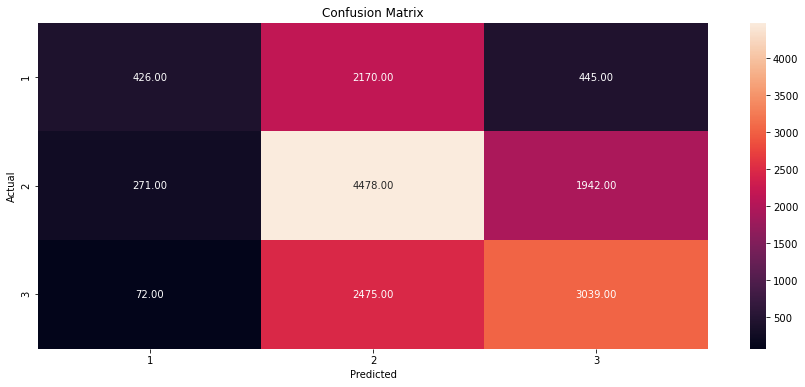

In [81]:
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'])
model_function(rfc,X_train,X_test,y_train,y_test)

***********************************************************************************************

Model Report for RandomForestClassifier(max_depth=9, max_features=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.38      0.52      0.44      3041
           2       0.51      0.34      0.41      6691
           3       0.53      0.63      0.58      5586

    accuracy                           0.48     15318
   macro avg       0.47      0.50      0.48     15318
weighted avg       0.49      0.48      0.48     15318



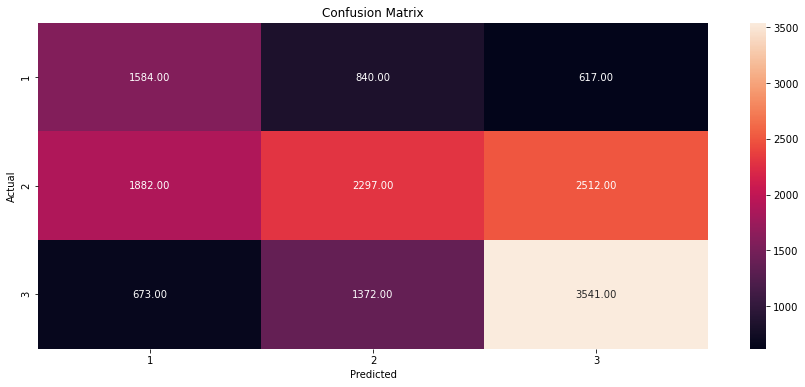

In [82]:
#Using SMOTE for train and only test for validation
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'])
model_function(rfc,X_train_smt,X_test,y_train_smt,y_test)

***********************************************************************************************

Model Report for RandomForestClassifier(max_depth=9, max_features=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.60      0.67      0.63      6691
           2       0.46      0.34      0.39      6691
           3       0.54      0.61      0.57      6691

    accuracy                           0.54     20073
   macro avg       0.53      0.54      0.53     20073
weighted avg       0.53      0.54      0.53     20073



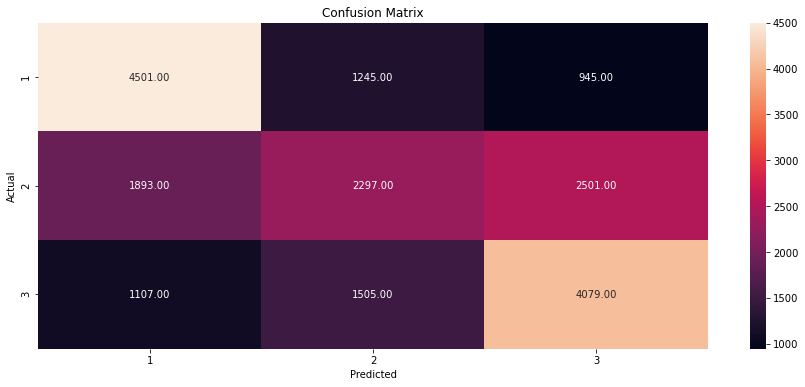

In [83]:
#Using SMOTE for train and SMOTE test
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'])
model_function(rfc,X_train_smt,X_test_smt,y_train_smt,y_test_smt)

###### Let us try with using RandomForests class weights parameter

In [84]:
from sklearn.utils import class_weight
wts = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
wts

array([1.64147079, 0.77196696, 0.91291017])

***********************************************************************************************

Model Report for RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.36      0.60      0.45      3041
           2       0.52      0.27      0.36      6691
           3       0.53      0.65      0.58      5586

    accuracy                           0.47     15318
   macro avg       0.47      0.51      0.46     15318
weighted avg       0.49      0.47      0.46     15318



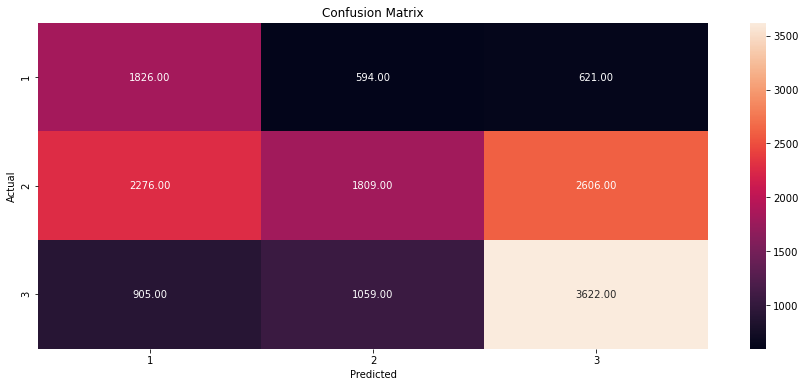

In [85]:
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'],
                             class_weight = 'balanced'
                    )
model_function(rfc,X_train,X_test,y_train,y_test)

***********************************************************************************************

Model Report for RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.38      0.52      0.44      3041
           2       0.51      0.35      0.42      6691
           3       0.53      0.63      0.58      5586

    accuracy                           0.49     15318
   macro avg       0.48      0.50      0.48     15318
weighted avg       0.49      0.49      0.48     15318



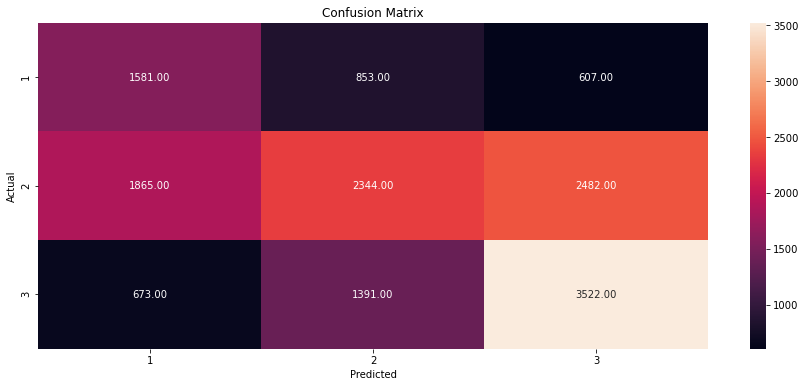

In [86]:
#Using SMOTE for train and only test for validation
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'],
                             class_weight = 'balanced'
                    )
model_function(rfc,X_train_smt,X_test,y_train_smt,y_test)

***********************************************************************************************

Model Report for RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.60      0.67      0.64      6691
           2       0.46      0.35      0.40      6691
           3       0.54      0.61      0.57      6691

    accuracy                           0.54     20073
   macro avg       0.53      0.54      0.53     20073
weighted avg       0.53      0.54      0.53     20073



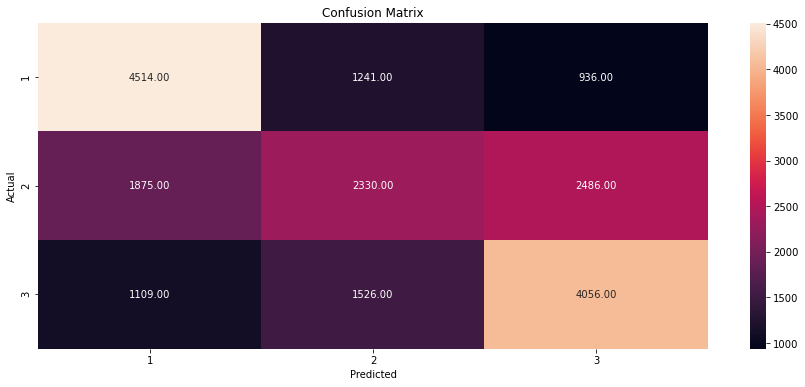

In [87]:
#Using SMOTE for train and only test for validation
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'],
                             class_weight = 'balanced'
                    )
model_function(rfc,X_train_smt,X_test_smt,y_train_smt,y_test_smt)

## Boosting Algorithms
* GradientBoostingClassifier

### GradientBoostingClassifier

***********************************************************************************************

Model Report for GradientBoostingClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.54      0.19      0.28      3041
           2       0.50      0.66      0.56      6691
           3       0.56      0.54      0.55      5586

    accuracy                           0.52     15318
   macro avg       0.53      0.46      0.47     15318
weighted avg       0.53      0.52      0.50     15318



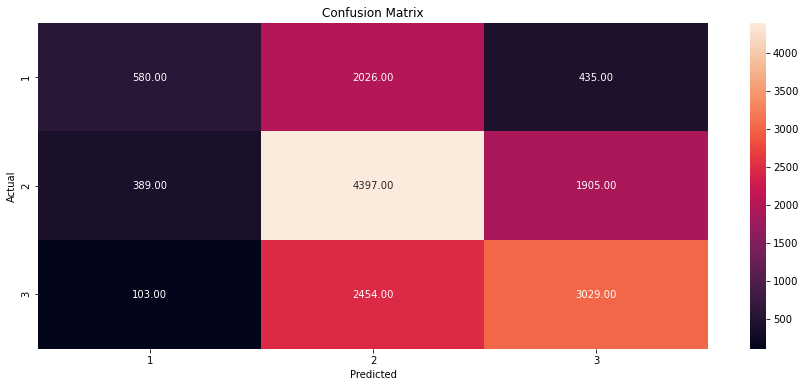

In [88]:
#Base GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model_function(gbc,X_train,X_test,y_train,y_test)

***********************************************************************************************

Model Report for GradientBoostingClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.39      0.50      0.44      3041
           2       0.50      0.39      0.44      6691
           3       0.54      0.61      0.57      5586

    accuracy                           0.49     15318
   macro avg       0.48      0.50      0.48     15318
weighted avg       0.49      0.49      0.49     15318



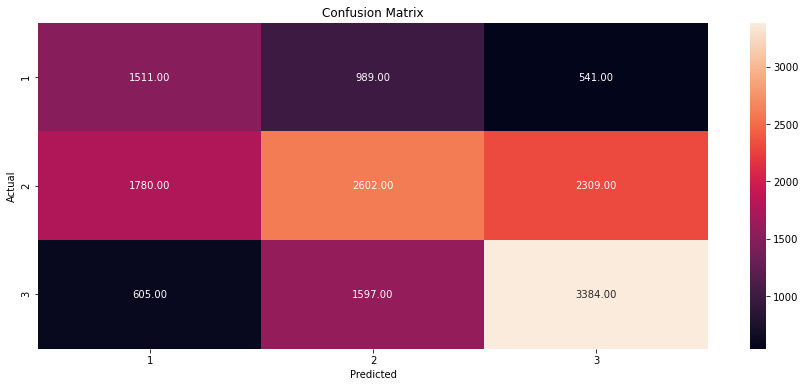

In [89]:
#SMOTE train only
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model_function(gbc,X_train_smt,X_test,y_train_smt,y_test)

***********************************************************************************************

Model Report for GradientBoostingClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.62      0.70      0.66      6691
           2       0.48      0.39      0.43      6691
           3       0.55      0.58      0.57      6691

    accuracy                           0.56     20073
   macro avg       0.55      0.56      0.55     20073
weighted avg       0.55      0.56      0.55     20073



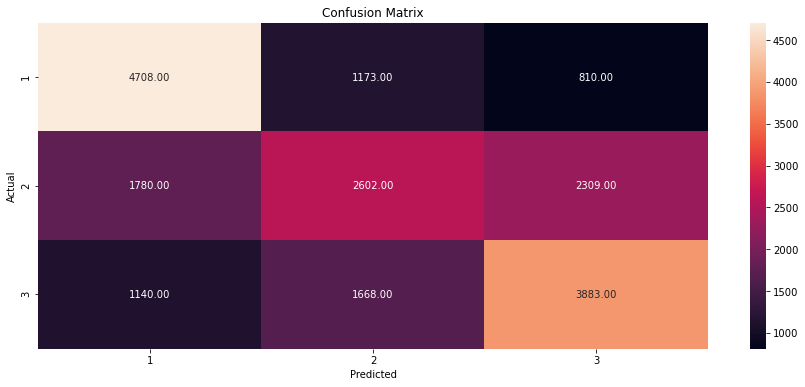

In [90]:
#SMOTE train and test
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model_function(gbc,X_train_smt,X_test_smt,y_train_smt,y_test_smt)

***********************************************************************************************

Model Report for GradientBoostingClassifier(learning_rate=0.15)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.53      0.21      0.30      3041
           2       0.49      0.65      0.56      6691
           3       0.57      0.54      0.55      5586

    accuracy                           0.52     15318
   macro avg       0.53      0.47      0.47     15318
weighted avg       0.53      0.52      0.51     15318



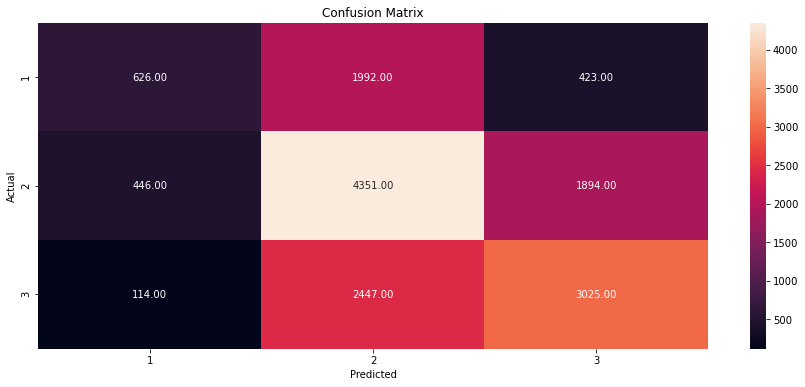

In [91]:
#Checking if increasing or decreasing learning rate has an impact
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate = 0.15)
model_function(gbc,X_train,X_test,y_train,y_test)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------------------------

# Performing clustering on the test set in which we will create target variable.

In [92]:
test = pd.read_csv('Data/capstone_test.csv')

In [93]:
test.isna().sum()[test.isna().sum()!=0]/len(test)
#Ignore the interest rate since that is the target variable.

Length_Employed            0.045061
Home_Owner                 0.152555
Annual_Income              0.154262
Months_Since_Deliquency    0.537324
dtype: float64

In [94]:
test.drop('Loan_ID',axis = 1,inplace = True)

In [95]:
def lar(x):
    return int(x.replace(',',''))
test['Loan_Amount_Requested'] = test['Loan_Amount_Requested'].apply(lar)

In [96]:
Q1 = test.drop(['Inquiries_Last_6Mo','Months_Since_Deliquency'],axis = 1).quantile(0.25)
Q3 = test.drop(['Inquiries_Last_6Mo','Months_Since_Deliquency'],axis = 1).quantile(0.75)
IQR = Q3-Q1
test_data1 = test[~((test<(Q1-1.5*IQR)) | (test>(Q3+1.5*IQR))).any(axis = 1)]

In [97]:
test_data1['Inquiries_Last_6Mo'] = test_data1['Inquiries_Last_6Mo'].astype(int)

## Feature Engineering(1)

In [98]:
def Mortgage_on_house(x):
    if x=='Mortgage':
        return 'Yes'
    else:
        return 'No'
test_data1['Mortgage_on_house'] = test_data1['Home_Owner'].apply(Mortgage_on_house)

In [99]:
test_data1['Number_Closed_Accounts'] = test_data1['Total_Accounts'] - test_data1['Number_Open_Accounts']

In [100]:
def length_employed_bin(x):
    try:
        temp = int(x.replace('years','').replace('year','').replace('<','').strip().strip('+'))
        if temp in [1]:
            return '0-1'
        elif temp in [2,3,4,5]:
            return '2-5'
        elif temp in [6,7,8,9]:
            return '6-9'
        elif temp>=10:
            return '10+'
    except:
        return np.nan
test_data1['Length_Employed'] = test_data1['Length_Employed'].apply(length_employed_bin)

In [101]:
def purp_bin(x):
    assets = [ 'home_improvement','renewable_energy','house','educational','small_business']
    liabilities = ['car','debt_consolidation','credit_card']
    other = ['major_purchase', 'other', 'medical', 'moving','wedding','vacation']
    if x in assets:
        return 'asset'
    elif x in liabilities:
        return 'liability'
    elif x in other:
        return 'misc.'
test_data1['Purpose_Of_Loan'] = test_data1['Purpose_Of_Loan'].apply(purp_bin)

In [102]:
def inc_correct(x):
    if x == 'not verified':
        return 'not verified'
    else:
        return 'verified'
test_data1['Income_Verified'] = test_data1['Income_Verified'].apply(inc_correct)

In [103]:
def deliquency(x):
    if x>150 and x<181:
        return 'good'
    elif x > 100 and x<150:
        return 'average'
    elif x <100 and x>50:
        return 'poor'
    elif x<50:
        return 'very poor'
    else:
        return 'good' #This will fill the nan as good since I am assuming that they have no past records of deliquency
test_data1['Months_Since_Deliquency'] = test_data1['Months_Since_Deliquency'].apply(deliquency)

In [104]:
test_data1 = test_data1.drop(['Total_Accounts','Number_Open_Accounts'],axis = 1)

## Filling Missing values

In [105]:
#Map to convert from categorical to numerical
cat_cols = test_data1.select_dtypes('object').columns
cat_cols_map = {}
for i in test_data1.select_dtypes('object'):
    temp = test_data1[i].dropna().unique()
    d = dict(zip(temp,list(range(len(temp)))))
    cat_cols_map.setdefault(i,d)

#To convert back to categorical
rev_cat_col_map = {}
for i in test_data1.select_dtypes('object'):
    temp = test_data1[i].dropna().unique()
    d = dict(zip(list(range(len(temp))),temp))
    rev_cat_col_map.setdefault(i,d)

###### Converting Categorical to numerical

In [106]:
for i in cat_cols:
    test_data1[i] = test_data1[i].map(cat_cols_map[i])
test_data1.head()

Loan_Amount_Requested  Length_Employed  Home_Owner  Annual_Income  \
0                  27500              0.0         0.0       129000.0   
1                  26000              0.0         NaN       110000.0   
2                   6075              1.0         1.0        75000.0   
3                  12000              0.0         0.0        73000.0   
5                   8000              2.0         0.0        39432.0   

   Income_Verified  Purpose_Of_Loan  Debt_To_Income  Inquiries_Last_6Mo  \
0                0                0           12.87                   0   
1                1                0           11.37                   0   
2                0                0            6.83                   2   
3                0                0            7.76                   0   
5                0                1            0.00                   2   

   Months_Since_Deliquency  Gender  Mortgage_on_house  Number_Closed_Accounts  
0                        0       0                  0                      27  
1                        1       0                  1                      17  
2                        1       0                  1                      15  
3                        1       0                  0                       2  
5                        1       1                  0                       1

###### Standardize the dataset since KNN is a distance based algorithm

In [107]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X = test_data1
# y = test_data1['Interest_Rate']
X_scaled = pd.DataFrame(ss.fit_transform(X),columns = X.columns)
X_scaled.head()

Loan_Amount_Requested  Length_Employed  Home_Owner  Annual_Income  \
0               1.682975        -1.199639   -0.915077       2.153578   
1               1.496572        -1.199639         NaN       1.502793   
2              -0.979484        -0.393373    0.619408       0.303980   
3              -0.243191        -1.199639   -0.915077       0.235476   
4              -0.740266         0.412892   -0.915077      -0.914289   

   Income_Verified  Purpose_Of_Loan  Debt_To_Income  Inquiries_Last_6Mo  \
0        -0.694309        -0.433298       -0.566402           -0.751029   
1         1.440281        -0.433298       -0.758736           -0.751029   
2        -0.694309        -0.433298       -1.340868            1.196582   
3        -0.694309        -0.433298       -1.221621           -0.751029   
4        -0.694309         1.157518       -2.216630            1.196582   

   Months_Since_Deliquency    Gender  Mortgage_on_house  \
0                -1.950665 -0.638052          -1.176453   
1                -0.368205 -0.638052           0.850013   
2                -0.368205 -0.638052           0.850013   
3                -0.368205 -0.638052          -1.176453   
4                -0.368205  1.567269          -1.176453   

   Number_Closed_Accounts  
0                1.680201  
1                0.462326  
2                0.218751  
3               -1.364487  
4               -1.486274

###### Applying KNNImputer

In [108]:
from sklearn.impute import KNNImputer
import time
start = time.time()
knn_impute = KNNImputer(n_neighbors = 10)
no_na = knn_impute.fit_transform(X_scaled)
end = time.time()
print('Execution Time:',(end-start)/60)

Execution Time: 3.814214658737183


###### Unscale

In [109]:
X_unscaled = pd.DataFrame(ss.inverse_transform(no_na),columns = X.columns).apply(round)
X_unscaled.head()

Loan_Amount_Requested  Length_Employed  Home_Owner  Annual_Income  \
0                27500.0              0.0         0.0       129000.0   
1                26000.0              0.0         1.0       110000.0   
2                 6075.0              1.0         1.0        75000.0   
3                12000.0              0.0         0.0        73000.0   
4                 8000.0              2.0         0.0        39432.0   

   Income_Verified  Purpose_Of_Loan  Debt_To_Income  Inquiries_Last_6Mo  \
0              0.0              0.0            13.0                 0.0   
1              1.0              0.0            11.0                 0.0   
2              0.0              0.0             7.0                 2.0   
3              0.0              0.0             8.0                 0.0   
4              0.0              1.0             0.0                 2.0   

   Months_Since_Deliquency  Gender  Mortgage_on_house  Number_Closed_Accounts  
0                      0.0     0.0                0.0                    27.0  
1                      1.0     0.0                1.0                    17.0  
2                      1.0     0.0                1.0                    15.0  
3                      1.0     0.0                0.0                     2.0  
4                      1.0     1.0                0.0                     1.0

###### Converting Numerical to categorical

In [110]:
for i in cat_cols:
    X_unscaled[i] = X_unscaled[i].map(rev_cat_col_map[i])
X_unscaled.head()

Loan_Amount_Requested Length_Employed Home_Owner  Annual_Income  \
0                27500.0             10+   Mortgage       129000.0   
1                26000.0             10+       Rent       110000.0   
2                 6075.0             0-1       Rent        75000.0   
3                12000.0             10+   Mortgage        73000.0   
4                 8000.0             6-9   Mortgage        39432.0   

  Income_Verified Purpose_Of_Loan  Debt_To_Income  Inquiries_Last_6Mo  \
0        verified       liability            13.0                 0.0   
1    not verified       liability            11.0                 0.0   
2        verified       liability             7.0                 2.0   
3        verified       liability             8.0                 0.0   
4        verified           asset             0.0                 2.0   

  Months_Since_Deliquency  Gender Mortgage_on_house  Number_Closed_Accounts  
0                    poor    Male               Yes                    27.0  
1                    good    Male                No                    17.0  
2                    good    Male                No                    15.0  
3                    good    Male               Yes                     2.0  
4                    good  Female               Yes                     1.0

In [111]:
X_unscaled['Annual_Income_Amt_Req'] = X_unscaled['Annual_Income']/X_unscaled['Loan_Amount_Requested']
X_unscaled = X_unscaled.drop(['Annual_Income','Loan_Amount_Requested'],axis = 1)

###### Saving the train and test files

In [112]:
X_unscaled.to_csv('Data/test_filled.csv',index = False)

### Preparing the data

In [113]:
test_data = pd.read_csv('Data/test_filled.csv')
test_data.head()

Length_Employed Home_Owner Income_Verified Purpose_Of_Loan  Debt_To_Income  \
0             10+   Mortgage        verified       liability            13.0   
1             10+       Rent    not verified       liability            11.0   
2             0-1       Rent        verified       liability             7.0   
3             10+   Mortgage        verified       liability             8.0   
4             6-9   Mortgage        verified           asset             0.0   

   Inquiries_Last_6Mo Months_Since_Deliquency  Gender Mortgage_on_house  \
0                 0.0                    poor    Male               Yes   
1                 0.0                    good    Male                No   
2                 2.0                    good    Male                No   
3                 0.0                    good    Male               Yes   
4                 2.0                    good  Female               Yes   

   Number_Closed_Accounts  Annual_Income_Amt_Req  
0                    27.0               4.690909  
1                    17.0               4.230769  
2                    15.0              12.345679  
3                     2.0               6.083333  
4                     1.0               4.929000

In [114]:
test_data1 = test_data.copy()
cat_cols = test_data1.select_dtypes('object').columns
cat_cols_map = {}
for i in test_data1.select_dtypes('object'):
    temp = test_data1[i].dropna().unique()
    d = dict(zip(temp,list(range(len(temp)))))
    cat_cols_map.setdefault(i,d)

In [115]:
for i in cat_cols:
    test_data1[i] = test_data1[i].map(cat_cols_map[i])
test_data1.head()

Length_Employed  Home_Owner  Income_Verified  Purpose_Of_Loan  \
0                0           0                0                0   
1                0           1                1                0   
2                1           1                0                0   
3                0           0                0                0   
4                2           0                0                1   

   Debt_To_Income  Inquiries_Last_6Mo  Months_Since_Deliquency  Gender  \
0            13.0                 0.0                        0       0   
1            11.0                 0.0                        1       0   
2             7.0                 2.0                        1       0   
3             8.0                 0.0                        1       0   
4             0.0                 2.0                        1       1   

   Mortgage_on_house  Number_Closed_Accounts  Annual_Income_Amt_Req  
0                  0                    27.0               4.690909  
1                  1                    17.0               4.230769  
2                  1                    15.0              12.345679  
3                  0                     2.0               6.083333  
4                  0                     1.0               4.929000

###### Standardizing the dataset for KMeans

In [116]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
test_scaled = pd.DataFrame(ss.fit_transform(test_data1),columns = test_data.columns)

### Applying KMeans clustering

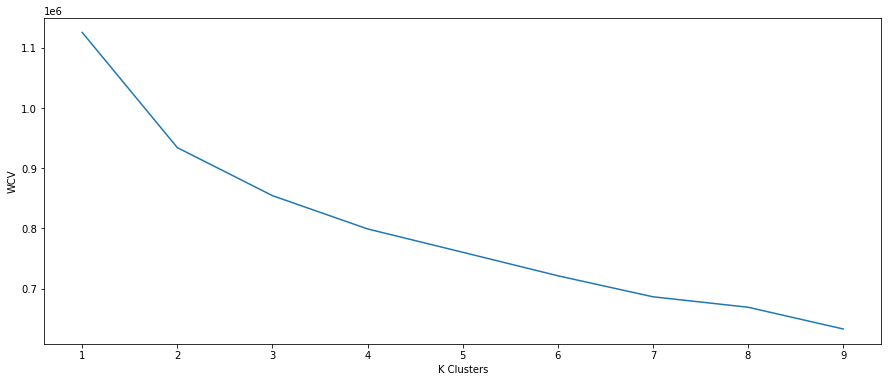

In [117]:
from sklearn.cluster import KMeans
wcv = []
for i in range(1,10):
    km = KMeans(n_clusters = i)
    km.fit(test_scaled)
    wcv.append(km.inertia_)
plt.figure(figsize = (15,6))
plt.plot(range(1,10),wcv)
plt.xlabel('K Clusters')
plt.ylabel('WCV')
plt.show()

###### According to the elbow method above, we can see 2,3 and 4 as the optimum number of clusters.

### Agglomerative Clustering

In [118]:
from sklearn.cluster import AgglomerativeClustering
hca = AgglomerativeClustering()

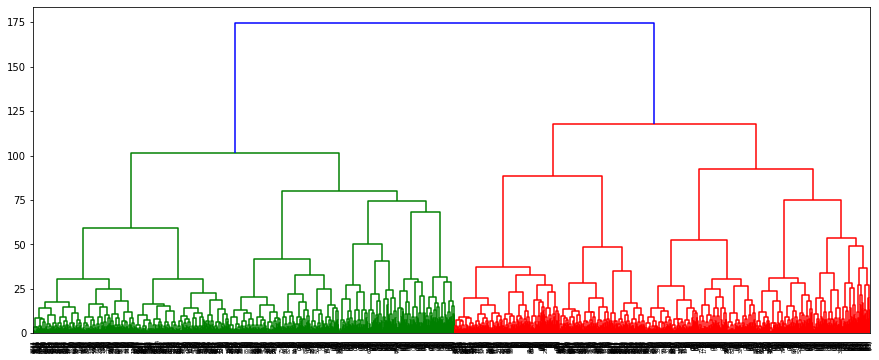

In [119]:
import scipy.cluster.hierarchy as sch
plt.figure(figsize = (15,6))
sch.dendrogram(sch.linkage(test_scaled.sample(10000),'ward'),p = 10,truncate_mode = 'level')
plt.show()
#We can see 2 main clusters and 3 overall clusters in the below dendrogram

### Applying KMeans with PCA

In [120]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(test_scaled)
cumsum = np.cumsum(pca.explained_variance_ratio_)
np.where(cumsum>0.95)[0][1]

10

In [121]:
pca = PCA(n_components = 0.95)
X_pca = pd.DataFrame(pca.fit_transform(test_scaled))

In [122]:
X_pca.head()

0         1         2         3         4         5         6  \
0 -2.008024 -0.628556 -0.465281  0.339124 -0.685355  1.937292  0.363948   
1  0.819584  0.127522 -0.275455 -1.340646 -0.760295  0.942413  0.424823   
2  0.688247  0.497387  0.913908  0.842720 -0.552495  0.323847 -0.648099   
3 -1.241064  0.205987 -1.597706 -0.182936 -0.614576  1.187560 -1.518650   
4 -0.928149  1.632761 -1.064686  1.761796  1.807810 -0.093629 -2.040437   

          7         8         9  
0  0.374962  1.824961 -0.288773  
1  1.293755  0.543851 -0.796820  
2  1.319046  0.819459  0.968757  
3  0.513111 -0.251498  0.685656  
4  0.564936 -0.264337 -0.317437

###### Applying KMeans

In [123]:
km = KMeans(n_clusters = 3)
km.fit(X_pca)
target_kmeans = pd.Series(km.predict(X_pca),name = 'Interest_Rate')

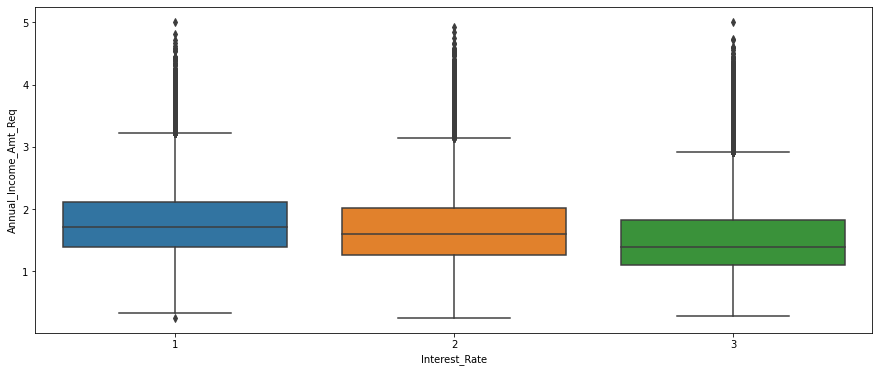

In [124]:
plt.figure(figsize = (15,6))
sns.boxplot(df['Interest_Rate'],np.log(df['Annual_Income_Amt_Req']))
plt.show()

In [125]:
complete_test = pd.concat((test_data,target_kmeans),axis = 1)

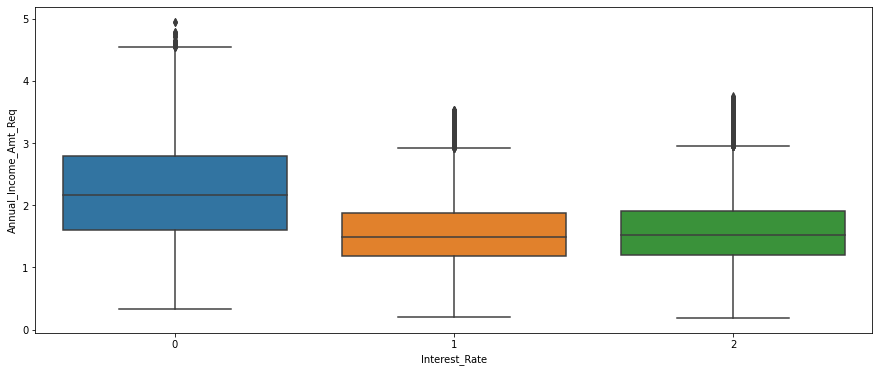

In [126]:
plt.figure(figsize = (15,6))
sns.boxplot(complete_test['Interest_Rate'],np.log(complete_test['Annual_Income_Amt_Req']))
plt.show()

In [127]:
complete_test['Interest_Rate'] = complete_test['Interest_Rate'].map({0:1,1:2,2:3})

In [128]:
master_data = pd.concat((complete_test,df))
master_data.to_csv('Data/master.csv',index = False)

# Classification on full data

In [129]:
master_data = pd.read_csv('Data/master.csv')

### Preparing the dataset for model building process

In [130]:
#Drop home_owner and gender column since we have already created a mortgage_on_house column from this feature and 
#gender is not playing any role in predicting rate of interest according to the statistical tests.
final_d = master_data.drop(['Home_Owner','Gender'],axis = 1)

In [131]:
#We can manually convert Months_Since_Deliquency since it is an ordinal column according to me.
deli_map = dict(zip(df['Months_Since_Deliquency'].unique(),[3,0,1,2]))
final_d['Months_Since_Deliquency'] = final_d['Months_Since_Deliquency'].map(deli_map)

In [132]:
#One Hot Encoding rest of the data
final_df = pd.get_dummies(final_d,drop_first = True)

In [133]:
#X y split
X = final_df.drop('Interest_Rate',axis = 1)
y = final_df['Interest_Rate']
X.head()

Debt_To_Income  Inquiries_Last_6Mo  Months_Since_Deliquency  \
0            13.0                 0.0                        1   
1            11.0                 0.0                        3   
2             7.0                 2.0                        3   
3             8.0                 0.0                        3   
4             0.0                 2.0                        3   

   Number_Closed_Accounts  Annual_Income_Amt_Req  Length_Employed_10+  \
0                    27.0               4.690909                    1   
1                    17.0               4.230769                    1   
2                    15.0              12.345679                    0   
3                     2.0               6.083333                    1   
4                     1.0               4.929000                    0   

   Length_Employed_2-5  Length_Employed_6-9  Income_Verified_verified  \
0                    0                    0                         1   
1                    0                    0                         0   
2                    0                    0                         1   
3                    0                    0                         1   
4                    0                    1                         1   

   Purpose_Of_Loan_liability  Purpose_Of_Loan_misc.  Mortgage_on_house_Yes  
0                          1                      0                      1  
1                          1                      0                      0  
2                          1                      0                      0  
3                          1                      0                      1  
4                          0                      0                      1

In [134]:
#Standardized X y split
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_scaled = pd.DataFrame(ss.fit_transform(X),columns = X.columns)
X_scaled.head()

Debt_To_Income  Inquiries_Last_6Mo  Months_Since_Deliquency  \
0       -0.547321           -0.749698                -0.537678   
1       -0.803406           -0.749698                 0.889798   
2       -1.315577            1.207704                 0.889798   
3       -1.187535           -0.749698                 0.889798   
4       -2.211877            1.207704                 0.889798   

   Number_Closed_Accounts  Annual_Income_Amt_Req  Length_Employed_10+  \
0                1.682286              -0.297730             1.454640   
1                0.463610              -0.373017             1.454640   
2                0.219875               0.954731            -0.687455   
3               -1.364404              -0.069904             1.454640   
4               -1.486272              -0.258774            -0.687455   

   Length_Employed_2-5  Length_Employed_6-9  Income_Verified_verified  \
0             -0.65684            -0.545137                  0.693451   
1             -0.65684            -0.545137                 -1.442063   
2             -0.65684            -0.545137                  0.693451   
3             -0.65684            -0.545137                  0.693451   
4             -0.65684             1.834400                  0.693451   

   Purpose_Of_Loan_liability  Purpose_Of_Loan_misc.  Mortgage_on_house_Yes  
0                   0.458002              -0.330181               1.177843  
1                   0.458002              -0.330181              -0.849010  
2                   0.458002              -0.330181              -0.849010  
3                   0.458002              -0.330181               1.177843  
4                  -2.183395              -0.330181               1.177843

### Train test split

In [135]:
#train test split for normal data
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state = 6)

In [136]:
#train test split for standardized data
from sklearn.model_selection import train_test_split
X1_train,X1_test,y1_train,y1_test = train_test_split(X_scaled,y,test_size = 0.1,random_state = 6)

### Model Building

###### Building the following Models:
* LogisticRegression
* DecisionTreeClassifier
* RandomForestClassifier

In [137]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X1_train,y1_train)
ypred = lr.predict(X1_test)

In [138]:
from sklearn.metrics import classification_report
print(classification_report(ypred,y1_test))

              precision    recall  f1-score   support

           1       0.26      0.51      0.35      2172
           2       0.74      0.66      0.70     13143
           3       0.64      0.59      0.62     10233

    accuracy                           0.62     25548
   macro avg       0.55      0.59      0.55     25548
weighted avg       0.66      0.62      0.63     25548



###### Applying SMOTE to increase data balance

In [139]:
from imblearn.over_sampling import SMOTE
s = SMOTE()
X_train_smt,y_train_smt = s.fit_resample(X_train,y_train)
X_test_smt,y_test_smt = s.fit_resample(X_test,y_test)

#### Retrying with Logistic Regression

In [140]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_smt,y_train_smt)
ypred_smt = lr.predict(X_test) #Predicting using the original test set.

In [141]:
from sklearn.metrics import classification_report
print(classification_report(ypred_smt,y_test))

              precision    recall  f1-score   support

           1       0.46      0.37      0.41      5276
           2       0.63      0.67      0.65     11122
           3       0.59      0.61      0.60      9150

    accuracy                           0.59     25548
   macro avg       0.56      0.55      0.55     25548
weighted avg       0.58      0.59      0.58     25548



###### Performance of our model has gone down on testing with the original test set. however if we notice, the f1-score of class 1 and class 3 has increased but of class 2 has decreased. This is because SMOTE has changed some of the class 2 samples into 3 and 1 samples.

In [142]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_smt,y_train_smt)
ypred_smt = lr.predict(X_test_smt) #Predicting using the SMOTE test set.

In [143]:
from sklearn.metrics import classification_report
print(classification_report(ypred_smt,y_test_smt))

              precision    recall  f1-score   support

           1       0.59      0.64      0.62     10810
           2       0.63      0.56      0.59     13422
           3       0.56      0.59      0.58     11102

    accuracy                           0.59     35334
   macro avg       0.59      0.60      0.59     35334
weighted avg       0.60      0.59      0.59     35334



###### On resampling both the train and test set we get an accuracy of 0.60. However we cannot resample the test set since this would mean us changing the real world data.

###### Creating a base  function for all models

In [144]:
def model_function(model,X_train,X_test,y_train,y_test):
    #Fitting the model
    model = model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print('*'*95)
    print("\n"+"\033[1m"+'Model Report for '+str(model)+"\033[0;0m"+"\n")
    print('*'*95)

    #Performance metrics
    from sklearn.metrics import classification_report
    print(classification_report(y_test,y_pred))

    #Confusion_Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize = (15,6))
    sns.heatmap(cm,annot = True,fmt = '.2f')
    plt.title('Confusion Matrix')
    plt.xticks([0.5,1.5,2.5],[1,2,3])
    plt.yticks([0.5,1.5,2.5],[1,2,3])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def grid_search(estimator,params,X_train,y_train,cv=5,v=0):
    from sklearn.model_selection import GridSearchCV
    grid = GridSearchCV(estimator,params,scoring = 'roc_auc',n_jobs = -1,cv = cv,verbose = v)
    grid.fit(X_train,y_train)
    return grid.best_params_

### DecisionTreeClassifier

***********************************************************************************************

Model Report for DecisionTreeClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.28      0.30      0.29      4265
           2       0.56      0.55      0.55     11778
           3       0.49      0.49      0.49      9505

    accuracy                           0.49     25548
   macro avg       0.45      0.45      0.45     25548
weighted avg       0.49      0.49      0.49     25548



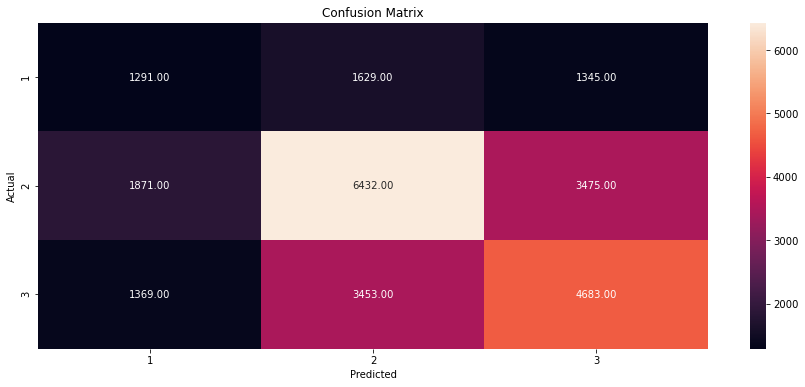

In [145]:
from sklearn.tree import DecisionTreeClassifier
dtf = DecisionTreeClassifier()
model_function(dtf,X_train,X_test,y_train,y_test)

###### Hyperparameter Tuning

In [146]:
params = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2,5,10],
              "max_depth": [5,10,20,50,100,150]
              }
grid_search(dtf,params,X_train,y_train,cv = 5)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

In [149]:
params = {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 2}

***********************************************************************************************

Model Report for DecisionTreeClassifier(max_depth=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.50      0.29      0.37      4265
           2       0.66      0.74      0.70     11778
           3       0.60      0.63      0.61      9505

    accuracy                           0.62     25548
   macro avg       0.59      0.55      0.56     25548
weighted avg       0.61      0.62      0.61     25548



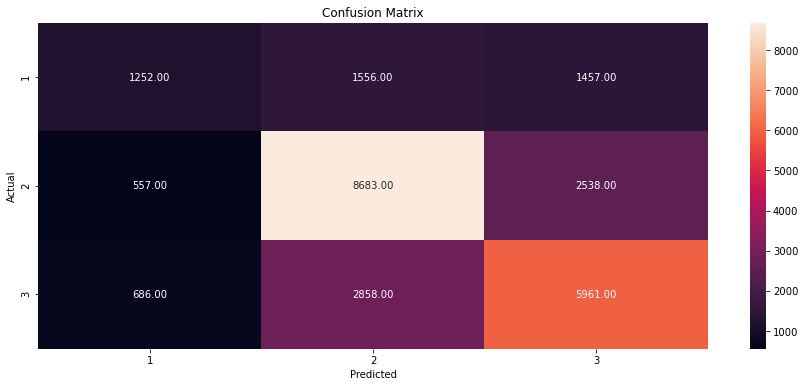

In [150]:
#Trying on the original train test data
dtf = DecisionTreeClassifier(criterion = params['criterion'],
                             max_depth = params['max_depth'],
                             min_samples_split = params['min_samples_split'])
model_function(dtf,X_train,X_test,y_train,y_test)
# We see an 8% score improvement after hyperparameter tuning. Recall has increased for interest rate 2 but there is
# a big fall in recall and f1-score for interest rate 1.

***********************************************************************************************

Model Report for DecisionTreeClassifier(max_depth=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.42      0.35      0.38      4265
           2       0.67      0.70      0.69     11778
           3       0.61      0.61      0.61      9505

    accuracy                           0.61     25548
   macro avg       0.56      0.56      0.56     25548
weighted avg       0.60      0.61      0.61     25548



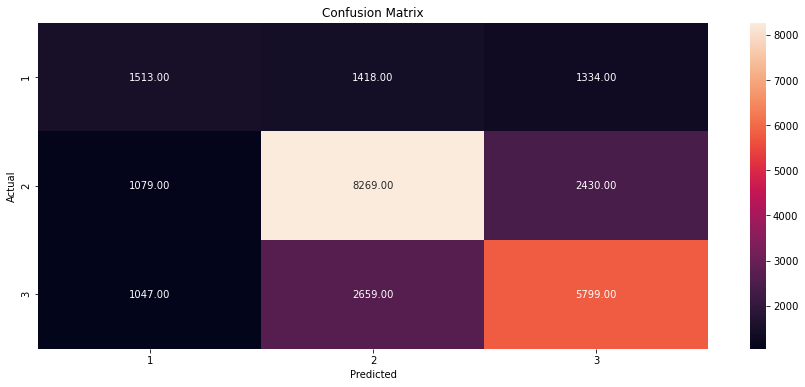

In [151]:
#Trying on the SMOTE resampled dataset with original test set
model_function(dtf,X_train_smt,X_test,y_train_smt,y_test)

###### There is slight improvement in the f1score of the minority classes however there is a decrease in f1score in the majority class

***********************************************************************************************

Model Report for DecisionTreeClassifier(max_depth=5)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.67      0.50      0.58     11778
           2       0.55      0.70      0.62     11778
           3       0.58      0.57      0.57     11778

    accuracy                           0.59     35334
   macro avg       0.60      0.59      0.59     35334
weighted avg       0.60      0.59      0.59     35334



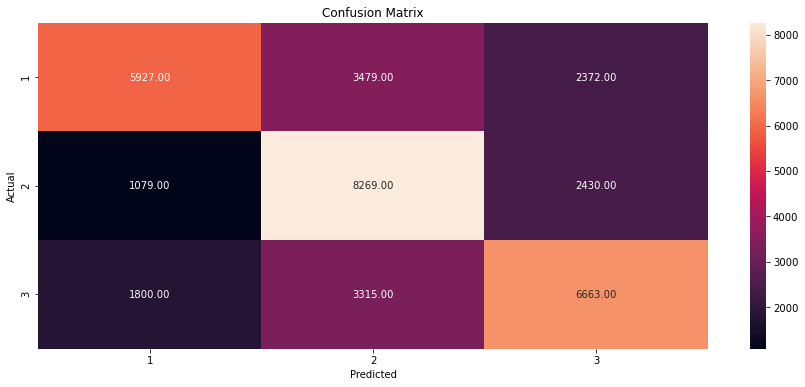

In [152]:
#Trying on the SMOTE resampled dataset with SMOTE test set
model_function(dtf,X_train_smt,X_test_smt,y_train_smt,y_test_smt)

###### On the SMOTE train and test sets we get a better overall f1-score.

### RandomForestClassifier

***********************************************************************************************

Model Report for RandomForestClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.43      0.31      0.36      4265
           2       0.62      0.67      0.64     11778
           3       0.56      0.57      0.57      9505

    accuracy                           0.57     25548
   macro avg       0.54      0.52      0.52     25548
weighted avg       0.57      0.57      0.57     25548



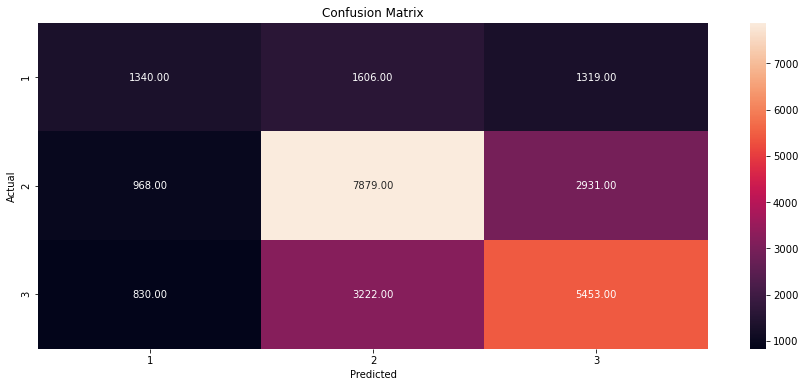

In [153]:
#Base model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
model_function(rfc,X_train,X_test,y_train,y_test)

In [ ]:
param = {'max_depth': [6,9, None], 
         'n_estimators':[50, 70, 100, 150], 
          'max_features': [np.random.randint(1,6)],
          'criterion' : ['gini', 'entropy'],
          'bootstrap':[True, False],
          'min_samples_leaf': [np.random.randint(1,4)]}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
rnd_search = RandomizedSearchCV(RandomForestClassifier(), param, n_iter =10, cv=9)
rnd_search.fit(X_train,y_train)
rnd_search.best_params_
rnd_search.best_score_

In [ ]:
rnd_search.best_params_

In [154]:
params = {'n_estimators': 70,
 'min_samples_leaf': 2,
 'max_features': 1,
 'max_depth': 9,
 'criterion': 'entropy',
 'bootstrap': True}

***********************************************************************************************

Model Report for RandomForestClassifier(max_depth=9, max_features=1, min_samples_leaf=2,
                       n_estimators=70)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.53      0.27      0.36      4265
           2       0.66      0.74      0.70     11778
           3       0.60      0.64      0.62      9505

    accuracy                           0.62     25548
   macro avg       0.59      0.55      0.56     25548
weighted avg       0.62      0.62      0.61     25548



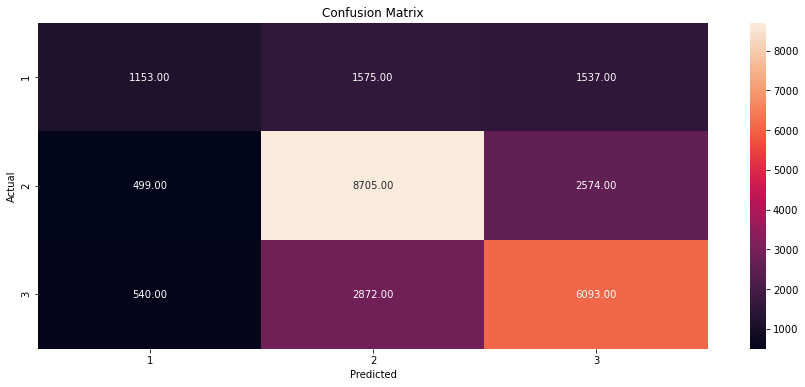

In [155]:
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'])
model_function(rfc,X_train,X_test,y_train,y_test)

***********************************************************************************************

Model Report for RandomForestClassifier(max_depth=9, max_features=1, min_samples_leaf=2,
                       n_estimators=70)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.39      0.47      0.43      4265
           2       0.67      0.65      0.66     11778
           3       0.62      0.59      0.60      9505

    accuracy                           0.60     25548
   macro avg       0.56      0.57      0.56     25548
weighted avg       0.61      0.60      0.60     25548



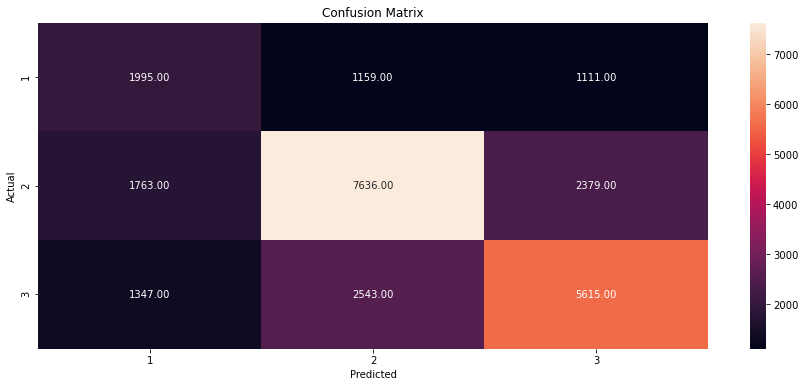

In [156]:
#Using SMOTE for train and only test for validation
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'])
model_function(rfc,X_train_smt,X_test,y_train_smt,y_test)

***********************************************************************************************

Model Report for RandomForestClassifier(max_depth=9, max_features=1, min_samples_leaf=2,
                       n_estimators=70)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.67      0.64      0.65     11778
           2       0.58      0.66      0.62     11778
           3       0.61      0.55      0.58     11778

    accuracy                           0.62     35334
   macro avg       0.62      0.62      0.62     35334
weighted avg       0.62      0.62      0.62     35334



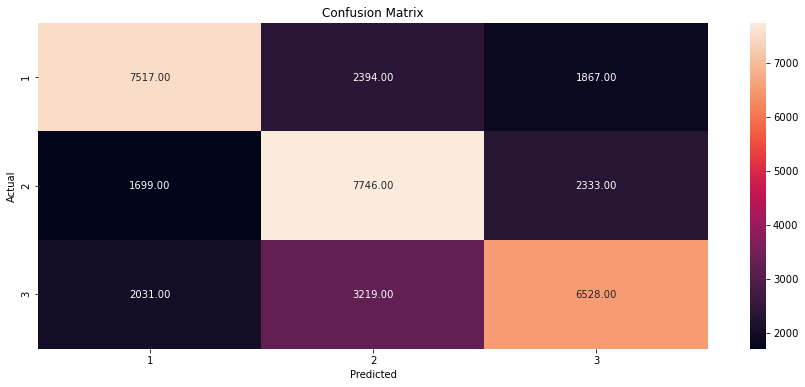

In [157]:
#Using SMOTE for train and SMOTE test
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'])
model_function(rfc,X_train_smt,X_test_smt,y_train_smt,y_test_smt)

###### Let us try with using RandomForests class weights parameter

In [158]:
from sklearn.utils import class_weight
wts = class_weight.compute_class_weight('balanced',np.unique(y_train),y_train)
wts

array([1.9950715 , 0.72350133, 0.89557796])

***********************************************************************************************

Model Report for RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=1,
                       min_samples_leaf=2, n_estimators=70)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.41      0.46      0.44      4265
           2       0.67      0.70      0.69     11778
           3       0.63      0.56      0.59      9505

    accuracy                           0.61     25548
   macro avg       0.57      0.57      0.57     25548
weighted avg       0.61      0.61      0.61     25548



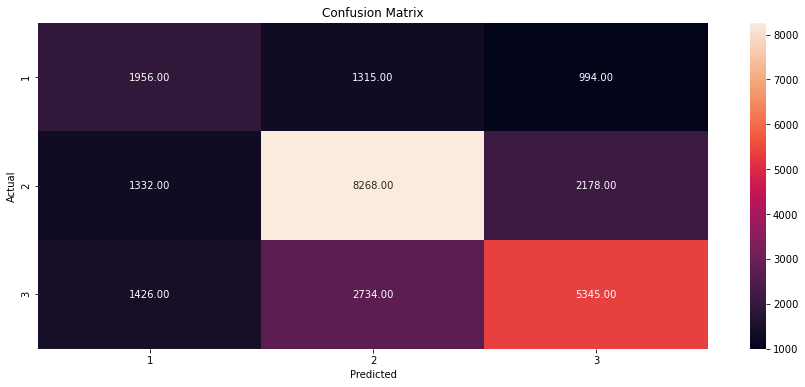

In [159]:
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'],
                             class_weight = 'balanced'
                    )
model_function(rfc,X_train,X_test,y_train,y_test)

***********************************************************************************************

Model Report for RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=1,
                       min_samples_leaf=2, n_estimators=70)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.39      0.47      0.43      4265
           2       0.67      0.64      0.66     11778
           3       0.61      0.60      0.61      9505

    accuracy                           0.60     25548
   macro avg       0.56      0.57      0.56     25548
weighted avg       0.60      0.60      0.60     25548



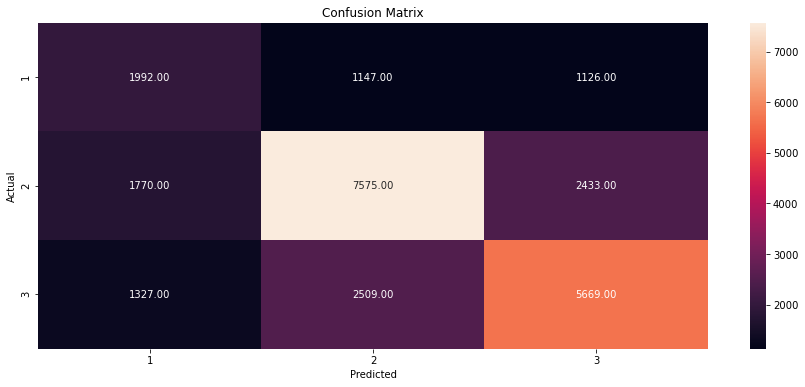

In [160]:
#Using SMOTE for train and only test for validation
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'],
                             class_weight = 'balanced'
                    )
model_function(rfc,X_train_smt,X_test,y_train_smt,y_test)

***********************************************************************************************

Model Report for RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=1,
                       min_samples_leaf=2, n_estimators=70)

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.66      0.64      0.65     11778
           2       0.58      0.65      0.61     11778
           3       0.61      0.55      0.58     11778

    accuracy                           0.61     35334
   macro avg       0.62      0.61      0.61     35334
weighted avg       0.62      0.61      0.61     35334



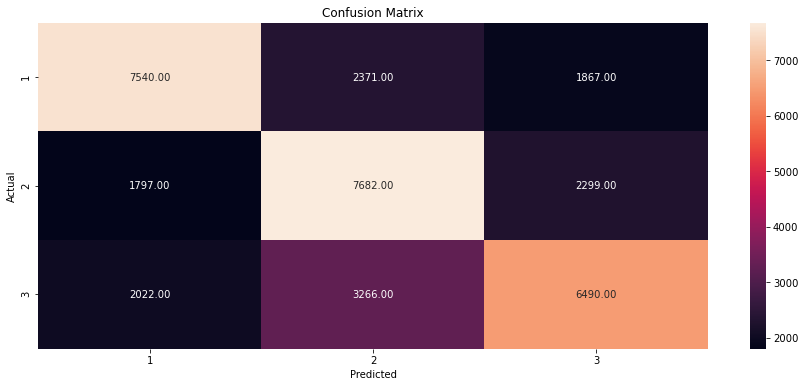

In [161]:
#Using SMOTE for train and only test for validation
#Tuned Model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = params['n_estimators'],
                             min_samples_leaf = params['min_samples_leaf'],
                             max_features = params['max_features'],
                            max_depth = params['max_depth'],
                             class_weight = 'balanced'
                    )
model_function(rfc,X_train_smt,X_test_smt,y_train_smt,y_test_smt)

## Boosting Algorithms
* GradientBoostingClassifier

### GradientBoostingClassifier

***********************************************************************************************

Model Report for GradientBoostingClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.52      0.30      0.38      4265
           2       0.67      0.73      0.70     11778
           3       0.60      0.63      0.62      9505

    accuracy                           0.63     25548
   macro avg       0.59      0.56      0.57     25548
weighted avg       0.62      0.63      0.62     25548



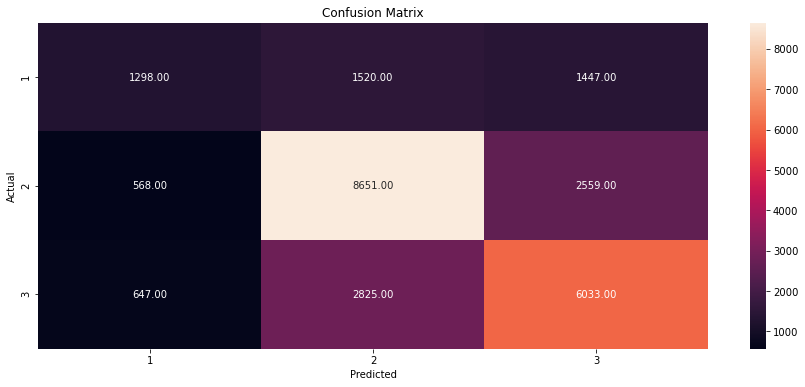

In [162]:
#Base GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model_function(gbc,X_train,X_test,y_train,y_test)

***********************************************************************************************

Model Report for GradientBoostingClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.41      0.45      0.43      4265
           2       0.67      0.66      0.66     11778
           3       0.61      0.61      0.61      9505

    accuracy                           0.60     25548
   macro avg       0.56      0.57      0.57     25548
weighted avg       0.61      0.60      0.60     25548



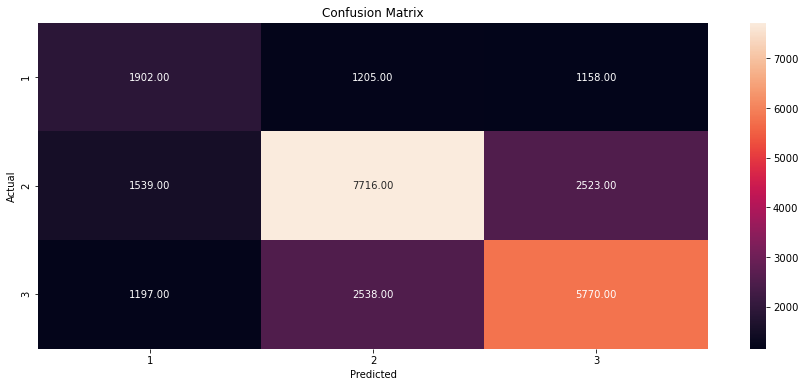

In [163]:
#SMOTE train only
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model_function(gbc,X_train_smt,X_test,y_train_smt,y_test)

***********************************************************************************************

Model Report for GradientBoostingClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.68      0.67      0.68     11778
           2       0.61      0.66      0.63     11778
           3       0.61      0.57      0.59     11778

    accuracy                           0.63     35334
   macro avg       0.63      0.63      0.63     35334
weighted avg       0.63      0.63      0.63     35334



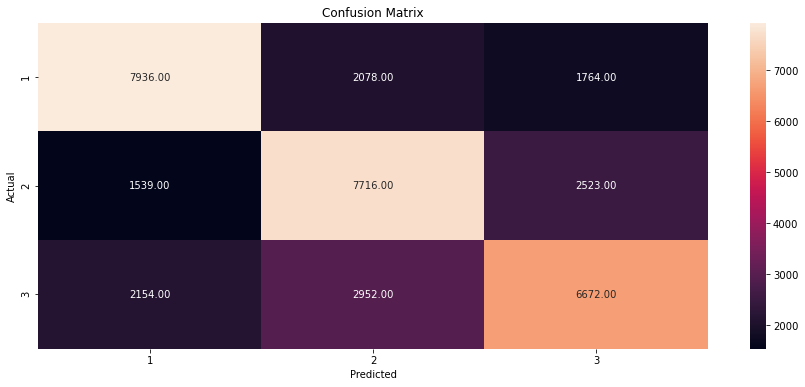

In [164]:
#SMOTE train and test
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model_function(gbc,X_train_smt,X_test_smt,y_train_smt,y_test_smt)

### AdaBoostClassifier

***********************************************************************************************

Model Report for AdaBoostClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.51      0.26      0.34      4265
           2       0.65      0.74      0.70     11778
           3       0.60      0.63      0.61      9505

    accuracy                           0.62     25548
   macro avg       0.59      0.54      0.55     25548
weighted avg       0.61      0.62      0.61     25548



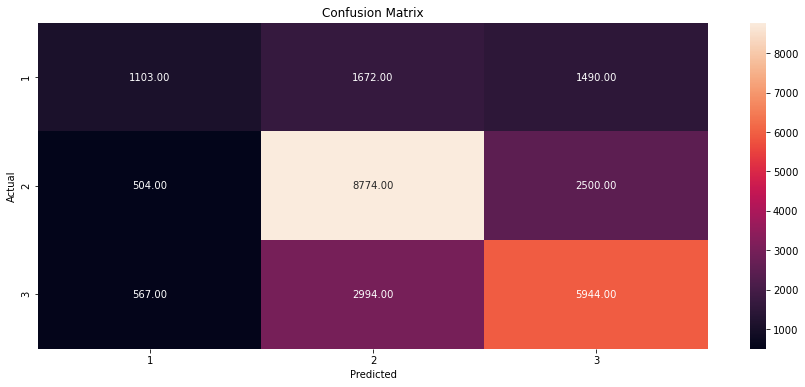

In [165]:
#Base GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
model_function(abc,X_train,X_test,y_train,y_test)

***********************************************************************************************

Model Report for AdaBoostClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.37      0.44      0.40      4265
           2       0.67      0.63      0.65     11778
           3       0.60      0.60      0.60      9505

    accuracy                           0.59     25548
   macro avg       0.55      0.56      0.55     25548
weighted avg       0.60      0.59      0.59     25548



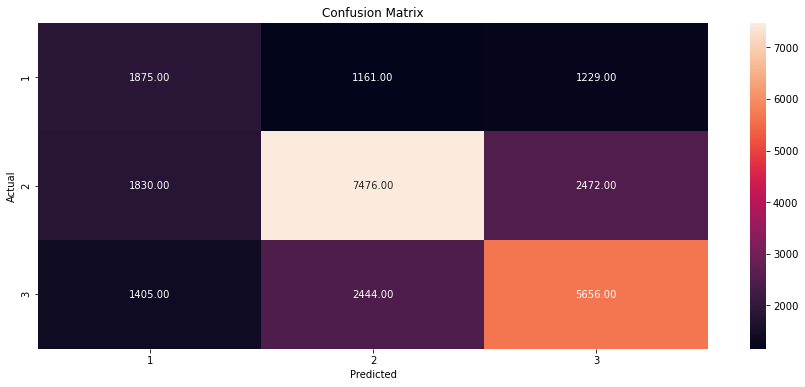

In [166]:
#SMOTE train only
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
model_function(abc,X_train_smt,X_test,y_train_smt,y_test)

***********************************************************************************************

Model Report for AdaBoostClassifier()

***********************************************************************************************
              precision    recall  f1-score   support

           1       0.65      0.65      0.65     11778
           2       0.59      0.63      0.61     11778
           3       0.60      0.56      0.58     11778

    accuracy                           0.61     35334
   macro avg       0.61      0.61      0.61     35334
weighted avg       0.61      0.61      0.61     35334



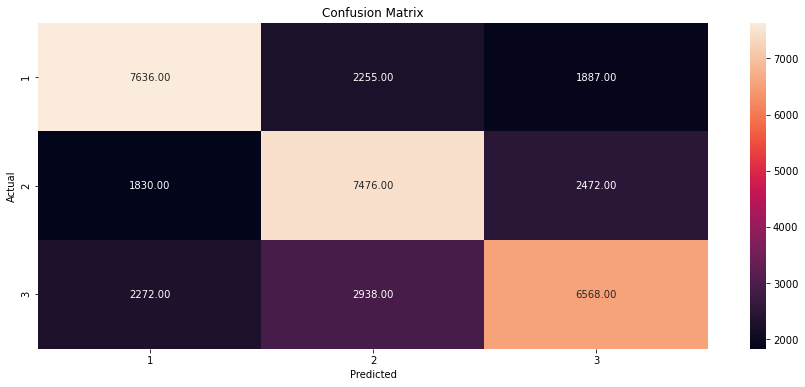

In [167]:
#SMOTE train and test
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
model_function(abc,X_train_smt,X_test_smt,y_train_smt,y_test_smt)

### XGBoostClassifier

[07:10:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***********************************************************************************************

Model Report for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_met

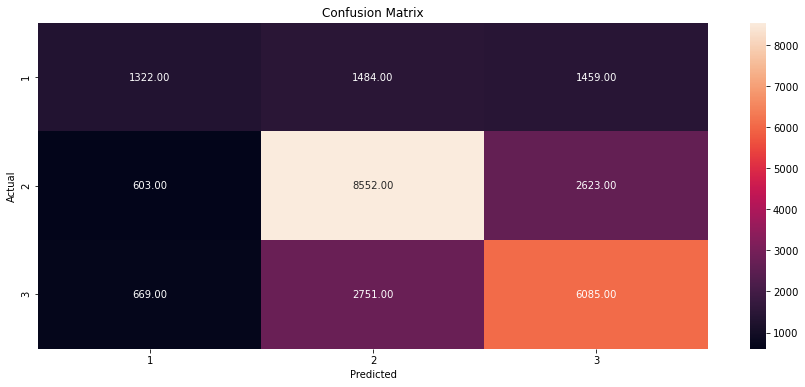

In [168]:
#Base XGB
import xgboost as xgb
from xgboost import XGBClassifier
xgbc = XGBClassifier()
model_function(xgbc,X_train,X_test,y_train,y_test)

[07:11:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***********************************************************************************************

Model Report for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_met

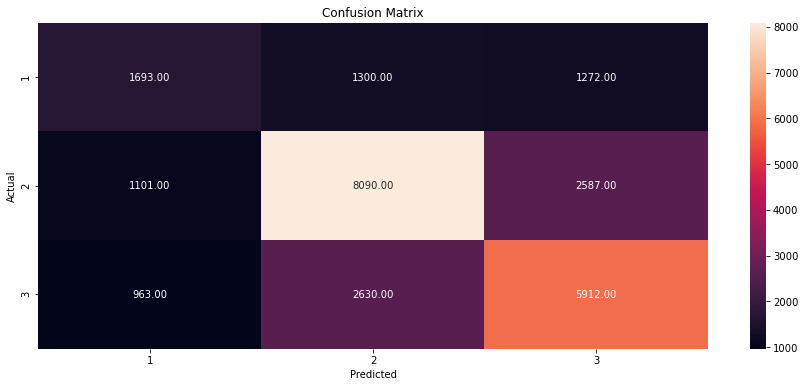

In [169]:
#SMOTE train only
model_function(xgbc,X_train_smt,X_test,y_train_smt,y_test)

[07:11:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***********************************************************************************************

Model Report for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_met

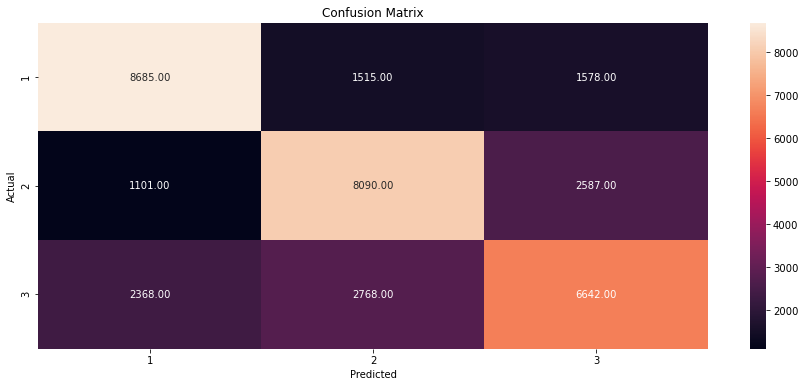

In [170]:
#SMOTE train and test
model_function(xgbc,X_train_smt,X_test_smt,y_train_smt,y_test_smt)

###### Hyperparameter Tuning for XGB

In [171]:
params = {"learning_rate": [0.10] ,
 "max_depth"        : [9],
 "min_child_weight" : [3, 5, 7],
 "gamma"            : [ 0.0, 0.1, 0.2],
 "colsample_bytree" : [0.4, 0.5 , 0.7] }
grid_search(xgbc,params,X_train,y_train,cv = 5,v=3)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[07:51:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 3}

In [230]:
params = {'colsample_bytree': 0.4,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 3}

[08:19:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***********************************************************************************************

Model Report for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=

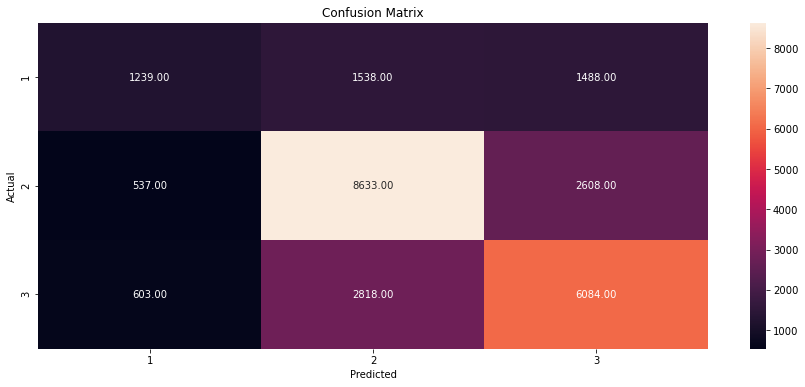

In [231]:
xgbc = XGBClassifier(colsample_bytree = params['colsample_bytree'],
                    gamma = params['gamma'],
                    learning_rate = params['learning_rate'],
                    max_depth = params['max_depth'],
                    min_child_weight = params['min_child_weight'])
model_function(xgbc,X_train,X_test,y_train,y_test)

[08:20:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
***********************************************************************************************

Model Report for XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=

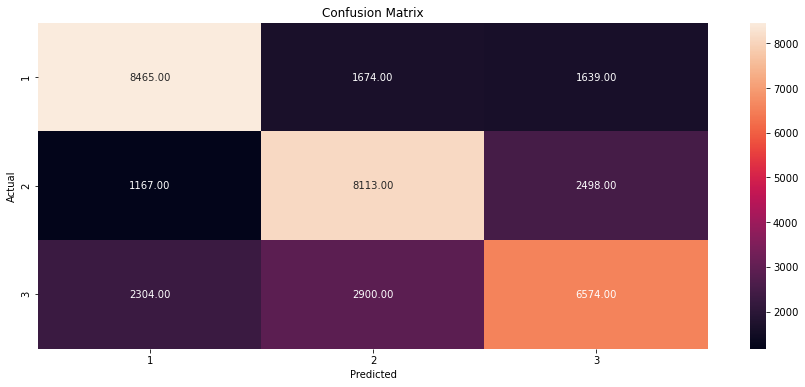

In [232]:
#SMOTE train and test
model_function(xgbc,X_train_smt,X_test_smt,y_train_smt,y_test_smt)